## Описание проекта

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и 
планирует будущие продажи. Для оптимизации процессов надо выделить пользователей 
которые готовы совершить покупку в ближайшее врем

### Цель
 Предсказать вероятность покупки в течение 90 днея.

### Задачи

- Изучить данные
- Разработать полезные признаки
- Создать модель для классификации пользователей
- Улучшить модель и максимизировать метрику **roc-auc**
- Выполнить тестирование

---

## Импорт библиотек и классов, написание пользовательских функций

In [6]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install category_encoders

Note: you may need to restart the kernel to use updated packages.


In [9]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import ast
import phik
import shap

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    StratifiedKFold,
    KFold,
    RepeatedKFold,
    cross_val_score,
)
from sklearn.metrics import roc_auc_score, make_scorer, accuracy_score, confusion_matrix
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    MinMaxScaler,
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler
from category_encoders.target_encoder import TargetEncoder
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
#чекаем инфо
def explore_dataset(df):
    print("Info:")
    df.info()
    
    print("\nDescribe:")
    display(df.describe())
    
    print("\nSample (n=2):")
    display(df.sample(n=2))
    
    print("\nКоличество пропусков в каждой колонке:")
    display(df.isnull().sum())
    
    print("\nКоличество уникальных значений в каждой колонке:")
    display(df.nunique())

In [12]:
#избавляемся от явных дубликатов
def count_and_remove_duplicates(df):
   
    duplicates_count = df.duplicated().sum()
    print(f'Количество явных дубликатов до удаления: {duplicates_count}')
    
    df.drop_duplicates(inplace=True)
    return None

In [13]:
#чекаем распределение по каналам коммуникации
def plot_events_by_channel(events_list, data):
   
    nrows = (len(events_list) // 3) + 1  
    fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(15, 5 * nrows))
    axes = axes.flatten()  

    for index, event in enumerate(events_list):
        ax = axes[index]
        filtered_data = data[data['event'] == event]
        grouped_data = filtered_data.groupby('channel')['event'].count()

        grouped_data.plot(kind='bar', ax=ax)
        ax.set_title(f'{event.capitalize()} Distribution by Channel')
        ax.set_xlabel('Channel')
        ax.set_ylabel('Count')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
        ax.grid(True)

   
    for i in range(index + 1, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [14]:
#чистим мусор в списках категорий
def clean_category_ids(row):
    # Удаляем лишние символы
    cleaned_row = row.replace("'", "").replace("[", "").replace("]", "")
    
    # Разделяем строку на элементы списка
    return cleaned_row.split(", ")

In [15]:
#чекам популярность покупок

def get_popularity(row):
    count = purchases['last_category'].value_counts()[row['last_category']]
    
    for lower_bound, upper_bound, category in categories:
        if lower_bound <= count <= upper_bound:
            return category
    return 'blockbuster'

In [16]:
#строим график по датам покупок. 
def plot_purchases(purchases, x_column, title, xlabel, ylabel):
    grouped_data = purchases.groupby(x_column)['date'].count().reset_index(name='кол-во')
   
    plt.figure(figsize=(10, 6))
    ax = grouped_data.plot(x=x_column, y='кол-во', kind='bar', color='green')
    ax.get_legend().remove()
    plt.xticks(rotation=60, ha='right')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

In [17]:
#чекаем детализацию рекламных кампаний по годам и месяцам (супер бесполезное по ощущением занятие)
def plot_column_by_year_and_month(df, column_name):
    grouped_by_year = df.groupby([df['date'].dt.year])[column_name].sum().reset_index()
    grouped_by_month = df.groupby([df['date'].dt.month])[column_name].sum().reset_index()
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    
    ax[0].bar(grouped_by_year['date'], grouped_by_year[column_name], width=0.7, align='center')
    ax[0].set_xticks(grouped_by_year['date'])
    ax[0].set_title(f'{column_name.capitalize()} по кампаниям (по годам)')
    ax[0].set_xlabel('Год')
    ax[0].set_ylabel(column_name.capitalize())
    ax[0].grid(axis='y')
    
    ax[1].plot(grouped_by_month['date'], grouped_by_month[column_name], marker='o', linestyle='-', label='По месяцам')
    ax[1].set_title(f'{column_name.capitalize()} по кампаниям (по месяцам)')
    ax[1].set_xlabel('Месяц')
    ax[1].set_ylabel(column_name.capitalize())
    ax[1].grid(True)
    
    plt.suptitle(f'{column_name.capitalize()} по кампаниям', fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()

In [18]:
#вносим категории успешности, получаем новый признак
def classify_campaign(row):
    if row['count_purchase_email'] == 0:
        return 'unsuccessful'
    elif row['count_purchase_email'] >= mean_purchases_email:
        return 'successful'
    else:
        return 'neutral'


---

## Изучение и обработка данных

Изучение датасетов начнем с прочтения файлов. Затем глянем стандартные вещи: размер; пропуски, типы данных, название колонок; уникальные значения; статистические данные.

In [22]:
messages = pd.read_csv(r'D:\Study\project\practikum_project\masterka_2\filtered_data\apparel-messages.csv')

In [23]:
purchases = pd.read_csv(r"D:\Study\project\practikum_project\masterka_2\filtered_data\apparel-purchases.csv")
target_binary = pd.read_csv(r"D:\Study\project\practikum_project\masterka_2\filtered_data\apparel-target_binary.csv")
campaign_daily_event = pd.read_csv(r"D:\Study\project\practikum_project\masterka_2\filtered_data\full_campaign_daily_event.csv")
campaign_daily_event_channel = pd.read_csv(r"D:\Study\project\practikum_project\masterka_2\filtered_data\full_campaign_daily_event_channel.csv")

In [24]:
explore_dataset(messages)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB

Describe:


,bulk_campaign_id,client_id
count,1.273980e+07,1.273980e+07
mean,1.160459e+04,1.515916e+18
std,3.259211e+03,3.265518e+08
min,5.480000e+02,1.515916e+18
25%,8.746000e+03,1.515916e+18
50%,1.351600e+04,1.515916e+18
75%,1.415800e+04,1.515916e+18
max,1.465700e+04,1.515916e+18



Sample (n=2):


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
8015733,13826,1515915625629507519,1515915625629507519-13826-6512c5b2ab0bc,open,mobile_push,2023-09-26,2023-09-26 13:42:58
8810675,14012,1515915625990746649,1515915625990746649-14012-653b1a101ce62,send,mobile_push,2023-10-27,2023-10-27 02:09:51



Количество пропусков в каждой колонке:


bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64


Количество уникальных значений в каждой колонке:


bulk_campaign_id       2709
client_id             53329
message_id          9061667
event                    11
channel                   2
date                    638
created_at          4103539
dtype: int64

**История рекламных рассылок**

- **bulk_campaign_id:** идентификатор рекламной кампании
- **client_id:** идентификатор пользователя
- **message_id:** идентификатор сообщений
- **event:** тип действия
- **channel:** каналы рассылки
- **date:** дата рассылки
- **created_at:** точное время создания сообщения

**Кратко:** 
1. датасет огромен, 12.7 млн записей: (пандас это вообще будет тянуть?)
2. date и  created_a имеют некорректные типы данных, поправим.
3. Статистические данные нам ничего не говорят потому что это по сути просто айдишки.
4. Пропуски в датасете отсутсвуют.
5. Всего было 2709 релкамных кампаний в которых участвовали 53к клиентов которым пришло 9 млн сообщений. Категорий этих писем всего 11, а способов доставки 2. Уникальных значений дат всего 638, остальное это разбивка на время.  

---

In [28]:
explore_dataset(purchases)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB

Describe:


,client_id,quantity,price
count,2.022080e+05,202208.000000,202208.000000
mean,1.515916e+18,1.006483,1193.301516
std,1.459514e+08,0.184384,1342.252664
min,1.515916e+18,1.000000,1.000000
25%,1.515916e+18,1.000000,352.000000
50%,1.515916e+18,1.000000,987.000000
75%,1.515916e+18,1.000000,1699.000000
max,1.515916e+18,30.000000,85499.000000



Sample (n=2):


,client_id,quantity,price,category_ids,date,message_id
81452,1515915625576920149,1,139.0,"['5562', '5536', '5656', '614']",2022-12-31,1515915625651659734-9110-63ae8def99dad
158686,1515915625889122634,1,599.0,"['4', '28', '244', '432']",2023-07-12,1515915625889122634-13475-64ad0c12bd088



Количество пропусков в каждой колонке:


client_id       0
quantity        0
price           0
category_ids    0
date            0
message_id      0
dtype: int64


Количество уникальных значений в каждой колонке:


client_id       49849
quantity           16
price            3642
category_ids      933
date              642
message_id      50204
dtype: int64

**apparel-purchases** Данные о покупках клиентов по дням и по товарам

- **client_id:** идентификатор клиента
- **quantity:** количество единиц товара
- **price:** цена товара
- **category_ids:** идентификаторы категорий
- **date:** дата покупки
- **message_id:** идентификатор сообщения из рассылки

**Кратко:**

1. датасет уже не такой огромный: 202к записей
2. date имеет некорректный тип данных, поправим
3. Максимальный заказ был на 30 товаров, а самый высокий чек 85к, а подавляющее кол-во заказв это 1 товар в пределаз 1.7к
4. Пропуски в датасете отсутствуют
5. Всего уникальных 50к клиентов, и для них было примерно столько же уникальных соообщений. Все это прошло за неполные 2 года.
6. Самое интересное это у нас идентификаторы категорий. У нас 933 униклаьных списка, но так как нумерация сквозная для всех уровней и дерево категорий обновляется переодически, то по идее тут будут неочевидные дубли. 

---

In [32]:
explore_dataset(target_binary)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB

Describe:


,client_id,target
count,4.984900e+04,49849.000000
mean,1.515916e+18,0.019278
std,1.487947e+08,0.137503
min,1.515916e+18,0.000000
25%,1.515916e+18,0.000000
50%,1.515916e+18,0.000000
75%,1.515916e+18,0.000000
max,1.515916e+18,1.000000



Sample (n=2):


,client_id,target
43300,1515915625809113337,0
3642,1515915625472379080,0



Количество пропусков в каждой колонке:


client_id    0
target       0
dtype: int64


Количество уникальных значений в каждой колонке:


client_id    49849
target           2
dtype: int64

**target** 
 - **client_id:** идентификатор клиента
 - **target:** клиент совершил покупку в целевом периоде


**Кратко:**
1. Тут в общем-то и так все ясно: была ли покупка или нет. Всего 50к клиентов. 

---

In [36]:
explore_dataset(campaign_daily_event)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   date                 131072 non-null  object
 1   bulk_campaign_id     131072 non-null  int64 
 2   count_click          131072 non-null  int64 
 3   count_complain       131072 non-null  int64 
 4   count_hard_bounce    131072 non-null  int64 
 5   count_open           131072 non-null  int64 
 6   count_purchase       131072 non-null  int64 
 7   count_send           131072 non-null  int64 
 8   count_soft_bounce    131072 non-null  int64 
 9   count_subscribe      131072 non-null  int64 
 10  count_unsubscribe    131072 non-null  int64 
 11  nunique_click        131072 non-null  int64 
 12  nunique_complain     131072 non-null  int64 
 13  nunique_hard_bounce  131072 non-null  int64 
 14  nunique_open         131072 non-null  int64 
 15  nunique_purchase     131072 

,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,count_unsubscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
count,131072.000000,131072.000000,131072.000000,131072.000000,1.310720e+05,131072.000000,1.310720e+05,131072.000000,131072.000000,131072.000000,...,1.310720e+05,131072.000000,1.310720e+05,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000
mean,8416.743378,90.982971,0.932655,78.473434,3.771091e+03,0.577927,1.163414e+04,27.807312,0.140518,6.362679,...,3.683000e+03,0.465103,1.153716e+04,27.573799,0.134125,5.960602,0.810364,0.809799,0.000008,0.000008
std,4877.369306,1275.503564,30.198326,1961.317826,6.516067e+04,9.107040,1.757095e+05,736.944714,2.072777,79.172069,...,6.258647e+04,7.126368,1.727005e+05,734.050700,1.976439,73.284148,183.298579,183.298245,0.002762,0.002762
min,548.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4116.000000,0.000000,0.000000,0.000000,1.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,1.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7477.000000,0.000000,0.000000,0.000000,6.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,6.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,13732.000000,2.000000,0.000000,0.000000,3.000000e+01,0.000000,0.000000e+00,0.000000,0.000000,1.000000,...,3.000000e+01,0.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,15150.000000,128453.000000,5160.000000,287404.000000,5.076151e+06,1077.000000,1.154351e+07,76284.000000,189.000000,9089.000000,...,2.922440e+06,779.000000,7.094600e+06,76281.000000,177.000000,8299.000000,63920.000000,63920.000000,1.000000,1.000000



Sample (n=2):


,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
12894,2022-08-02,3177,0,0,0,8,0,0,0,0,...,8,0,0,0,0,0,0,0,0,0
82193,2023-08-02,13577,0,0,0,4,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0



Количество пропусков в каждой колонке:


date                   0
bulk_campaign_id       0
count_click            0
count_complain         0
count_hard_bounce      0
count_open             0
count_purchase         0
count_send             0
count_soft_bounce      0
count_subscribe        0
count_unsubscribe      0
nunique_click          0
nunique_complain       0
nunique_hard_bounce    0
nunique_open           0
nunique_purchase       0
nunique_send           0
nunique_soft_bounce    0
nunique_subscribe      0
nunique_unsubscribe    0
count_hbq_spam         0
nunique_hbq_spam       0
count_close            0
nunique_close          0
dtype: int64


Количество уникальных значений в каждой колонке:


date                    727
bulk_campaign_id       3181
count_click            2284
count_complain          249
count_hard_bounce      1283
count_open             5321
count_purchase          192
count_send             2821
count_soft_bounce       741
count_subscribe          85
count_unsubscribe       697
nunique_click          2118
nunique_complain        238
nunique_hard_bounce    1277
nunique_open           5287
nunique_purchase        177
nunique_send           2822
nunique_soft_bounce     738
nunique_subscribe        79
nunique_unsubscribe     670
count_hbq_spam          104
nunique_hbq_spam        105
count_close               2
nunique_close             2
dtype: int64

**campaign_daily_event** - Агрегация общей базы рассылок по дням и типам событий

1. **date** – Дата
2. **bulk_campaign_id** – Идентификатор массовой рекламной кампании
3. **count_click** – Количество кликов
4. **count_complain** – Количество жалоб
5. **count_hard_bounce** – Количество жёстких возвратов
6. **count_open** – Количество открытий
7. **count_purchase** – Количество покупок
8. **count_send** – Количество отправленных писем
9. **count_soft_bounce** – Количество мягких возвратови10 в**count_subscribe** – Количество подписок
11. **count_unsubscribe** – Количество отписок
12. **nunique_click** – Уникальные клики
13. **nunique_complain** – Уникальные жалобы
14. **nunique_hard_bounce** – Уникальные жёсткие возвраты
15. **nunique_open** – Уникальные открытия
16. **nunique_purchase** – Уникальные покупки
17. **nunique_send** – Уникальные отправления
18. **nunique_soft_bounce** – Уникальные мягкие возвраты
19. **nunique_subscribe** – Уникальные подписки
20. **nunique_unsubscribe** – Уникальные отписки
21. **count_hbq_spam** – Количество жалоб на спам
22. **nunique_hbq_spam** – Уникальные жалобы на спам
23. **count_close** – Количество закрытий
24. **nunique_close** – Уникальные закрытияей закрыли письмо).

**Кратко:**

1. Датасет 131к записей
2. date имеет некорректный тип данных, поправим
3. Очень много статистических данных: описывать кратко не получится) 
4. Пропуски в датасете отсутствуют
5. Всего уникальных 727 дат, больше, чем в других табличках. Было провдено более 3к рекламных кампаний (Это что за конвеер там в маркетинге? 4 кампании в день). В остальном ничгео выдающегося на первый взгляд
6. Как видится на текущий момент Данный датасет будет полезен для создания  синтетических признаков. Можно будет определить удачные и не очень рекламные кампании. 

---

In [40]:
explore_dataset(campaign_daily_event_channel)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   date                             131072 non-null  object
 1   bulk_campaign_id                 131072 non-null  int64 
 2   count_click_email                131072 non-null  int64 
 3   count_click_mobile_push          131072 non-null  int64 
 4   count_open_email                 131072 non-null  int64 
 5   count_open_mobile_push           131072 non-null  int64 
 6   count_purchase_email             131072 non-null  int64 
 7   count_purchase_mobile_push       131072 non-null  int64 
 8   count_soft_bounce_email          131072 non-null  int64 
 9   count_subscribe_email            131072 non-null  int64 
 10  count_unsubscribe_email          131072 non-null  int64 
 11  nunique_click_email              131072 non-null  int64 
 12  nunique_cl

,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,count_unsubscribe_email,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
count,131072.000000,131072.000000,131072.000000,1.310720e+05,1.310720e+05,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,...,1.310720e+05,131072.000000,131072.000000,1.310720e+05,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000
mean,8416.743378,41.582169,49.400803,4.237060e+02,3.347385e+03,0.357483,0.220444,24.474823,0.140518,6.362679,...,4.189581e+03,18.535683,0.809799,4.186898e+03,3.332489,3.311653,0.932655,0.921326,0.000008,0.000008
std,4877.369306,745.484035,1036.952898,9.753384e+03,6.444859e+04,8.287483,3.796500,727.069387,2.072777,79.172069,...,1.073198e+05,1349.473695,183.298245,1.072618e+05,120.916269,120.094858,30.198326,29.715170,0.002762,0.002762
min,548.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4116.000000,0.000000,0.000000,1.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7477.000000,0.000000,0.000000,5.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,13732.000000,1.000000,0.000000,2.300000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,15150.000000,59365.000000,128453.000000,2.597015e+06,5.076151e+06,1077.000000,431.000000,76284.000000,189.000000,9089.000000,...,7.094600e+06,287341.000000,63920.000000,7.094600e+06,21831.000000,21389.000000,5160.000000,5043.000000,1.000000,1.000000



Sample (n=2):


,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
5650,2022-06-24,3249,0,0,10,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24490,2022-09-29,1599,0,0,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



Количество пропусков в каждой колонке:


date                               0
bulk_campaign_id                   0
count_click_email                  0
count_click_mobile_push            0
count_open_email                   0
count_open_mobile_push             0
count_purchase_email               0
count_purchase_mobile_push         0
count_soft_bounce_email            0
count_subscribe_email              0
count_unsubscribe_email            0
nunique_click_email                0
nunique_click_mobile_push          0
nunique_open_email                 0
nunique_open_mobile_push           0
nunique_purchase_email             0
nunique_purchase_mobile_push       0
nunique_soft_bounce_email          0
nunique_subscribe_email            0
nunique_unsubscribe_email          0
count_hard_bounce_mobile_push      0
count_send_mobile_push             0
nunique_hard_bounce_mobile_push    0
nunique_send_mobile_push           0
count_hard_bounce_email            0
count_hbq_spam_email               0
count_send_email                   0
n


Количество уникальных значений в каждой колонке:


date                                727
bulk_campaign_id                   3181
count_click_email                  1375
count_click_mobile_push            1560
count_open_email                   3785
count_open_mobile_push             2883
count_purchase_email                172
count_purchase_mobile_push          113
count_soft_bounce_email             497
count_subscribe_email                85
count_unsubscribe_email             697
nunique_click_email                1249
nunique_click_mobile_push          1460
nunique_open_email                 3740
nunique_open_mobile_push           2887
nunique_purchase_email              156
nunique_purchase_mobile_push         99
nunique_soft_bounce_email           493
nunique_subscribe_email              79
nunique_unsubscribe_email           670
count_hard_bounce_mobile_push      1035
count_send_mobile_push             2365
nunique_hard_bounce_mobile_push    1029
nunique_send_mobile_push           2365
count_hard_bounce_email             373


**campaign_daily_event_channel** Агрегация по дням с учетом событий и каналов рассылки

1. **Date** – Дата
2. **Bulk Campaign ID** – Идентификатор массовой рекламной кампании
3. **Count Click Email** – Количество кликов по электронной почте
4. **Count Click Mobile Push** – Количество кликов по мобильному пуш-уведомлению
5. **Count Open Email** – Количество открытий по электронной почте
6. **Count Open Mobile Push** – Количество открытий мобильного пуш-уведомления
7. **Count Purchase Email** – Количество покупок по электронной почте
8. **Count Purchase Mobile Push** – Количество покупок по мобильному пуш-уведомлению
9. **Count Soft Bounce Email** – Количество мягких возвратов по электронной почте
10. **Count Subscribe Email** – Количество подписок по электронной почте
11. **Count Unsubscribe Email** – Количество отписок по электронной почте
12. **Nunique Click Email** – Уникальные клики по электронной почте
13. **Nunique Click Mobile Push** – Уникальные клики по мобильному пуш-уведомлению
14. **Nunique Open Email** – Уникальные открытия по электронной почте
15. **Nunique Open Mobile Push** – Уникальные открытия мобильного пуш-уведомления
16. **Nunique Purchase Email** – Уникальные покупки по электронной почте
17. **Nunique Purchase Mobile Push** – Уникальные покупки по мобильному пуш-уведомлению
18. **Nunique Soft Bounce Email** – Уникальные мягкие возвраты по электронной почте
19. **Nunique Subscribe Email** – Уникальные подписки по электронной почте
20. **Nunique Unsubscribe Email** – Уникальные отписки по электронной почте
21. **Count Hard Bounce Mobile Push** – Количество жестких возвратов мобильного пуш-уведомления
22. **Count Send Mobile Push** – Количество отправленных мобильных пуш-уведомлений
23. **Nunique Hard Bounce Mobile Push** – Уникальные жесткие возвраты мобильного пуш-уведомления
24. **Nunique Send Mobile Push** – Уникальные отправки мобильных пуш-уведомлений
25. **Count Hard Bounce Email** – Количество жестких возвратов по электронной почте
26. **Count HBQ Spam Email** – Количество жалоб на спам по электронной почте
27. **Count Send Email** – Количество отправленных писем по электронной почте
28. **Nunique Hard Bounce Email** – Уникальные жесткие возвраты по электронной почте
29. **Nunique HBQ Spam Email** – Уникальные жалобы на спам по электронной почте
30. **Nunique Send Email** – Уникальные отправки писем по электронной почте
31. **Count Soft Bounce Mobile Push** – Количество мягких возвратов мобильного пуш-уведомления
32. **Nunique Soft Bounce Mobile Push** – Уникальные мягкие возвраты мобильного пуш-уведомления
33. **Count Complain Email** – Количество жалоб по электронной почте
34. **Nunique Complain Email** – Уникальные жалобы по электронной почте
35. **Count Close Mobile Push** – Количество закрытий мобильного пуш-уведомления
36. **Nunique Close Mobile Push** – Уникальные закрытия мобильного пуш-уведомлениякрытия мобильного пуш-уведомления


**Кратко:**

1. Датасет 131к записей
2. date имеет некорректный тип данных, поправим
3. Очень много статистических данных: описывать кратко не получится) 
4. Пропуски в датасете отсутствуют
5. Всего уникальных 727 дат, больше, чем в других табличках. Было провдено более 3к рекламных кампаний (Это что за конвеер там в маркетинге? 4 кампании в день). В остальном ничгео выдающегося на первый взгляд
6. Как видится на текущий момент Данный датасет будет полезен для создания  синтетических признаков. Можно будет определить удачные и не очень рекламные кампании. А так же способ уведомления: пуши или почта. 

In [43]:
messages['date'] = pd.to_datetime(messages['date'])
messages['created_at'] = pd.to_datetime(messages['created_at'])
purchases['date'] = pd.to_datetime(purchases['date'])
campaign_daily_event['date'] = pd.to_datetime(campaign_daily_event['date'])
campaign_daily_event_channel['date'] = pd.to_datetime(campaign_daily_event_channel['date'])

Также надо проверить наличие дубликатов в датасетах. После этого можно будет переходить к изучению графиков.

In [45]:
count_and_remove_duplicates(messages) 
count_and_remove_duplicates(target_binary)
#count_and_remove_duplicates(purchases) #UPD: во время созвона вынесли предположение, что дубли вовсе и не дубли. Не буду убирать, оставлю на EDA. 
count_and_remove_duplicates(campaign_daily_event)
count_and_remove_duplicates(campaign_daily_event_channel)

Количество явных дубликатов до удаления: 48610
Количество явных дубликатов до удаления: 0
Количество явных дубликатов до удаления: 0
Количество явных дубликатов до удаления: 0


## Исследовательский и корреляционный анализ данных

Итак, переходим к исследовательскому анализу данных. Начинаем все с дефолтного изучения: чекаем усы; гистоаграммы.

In [48]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12691188 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 774.6+ MB


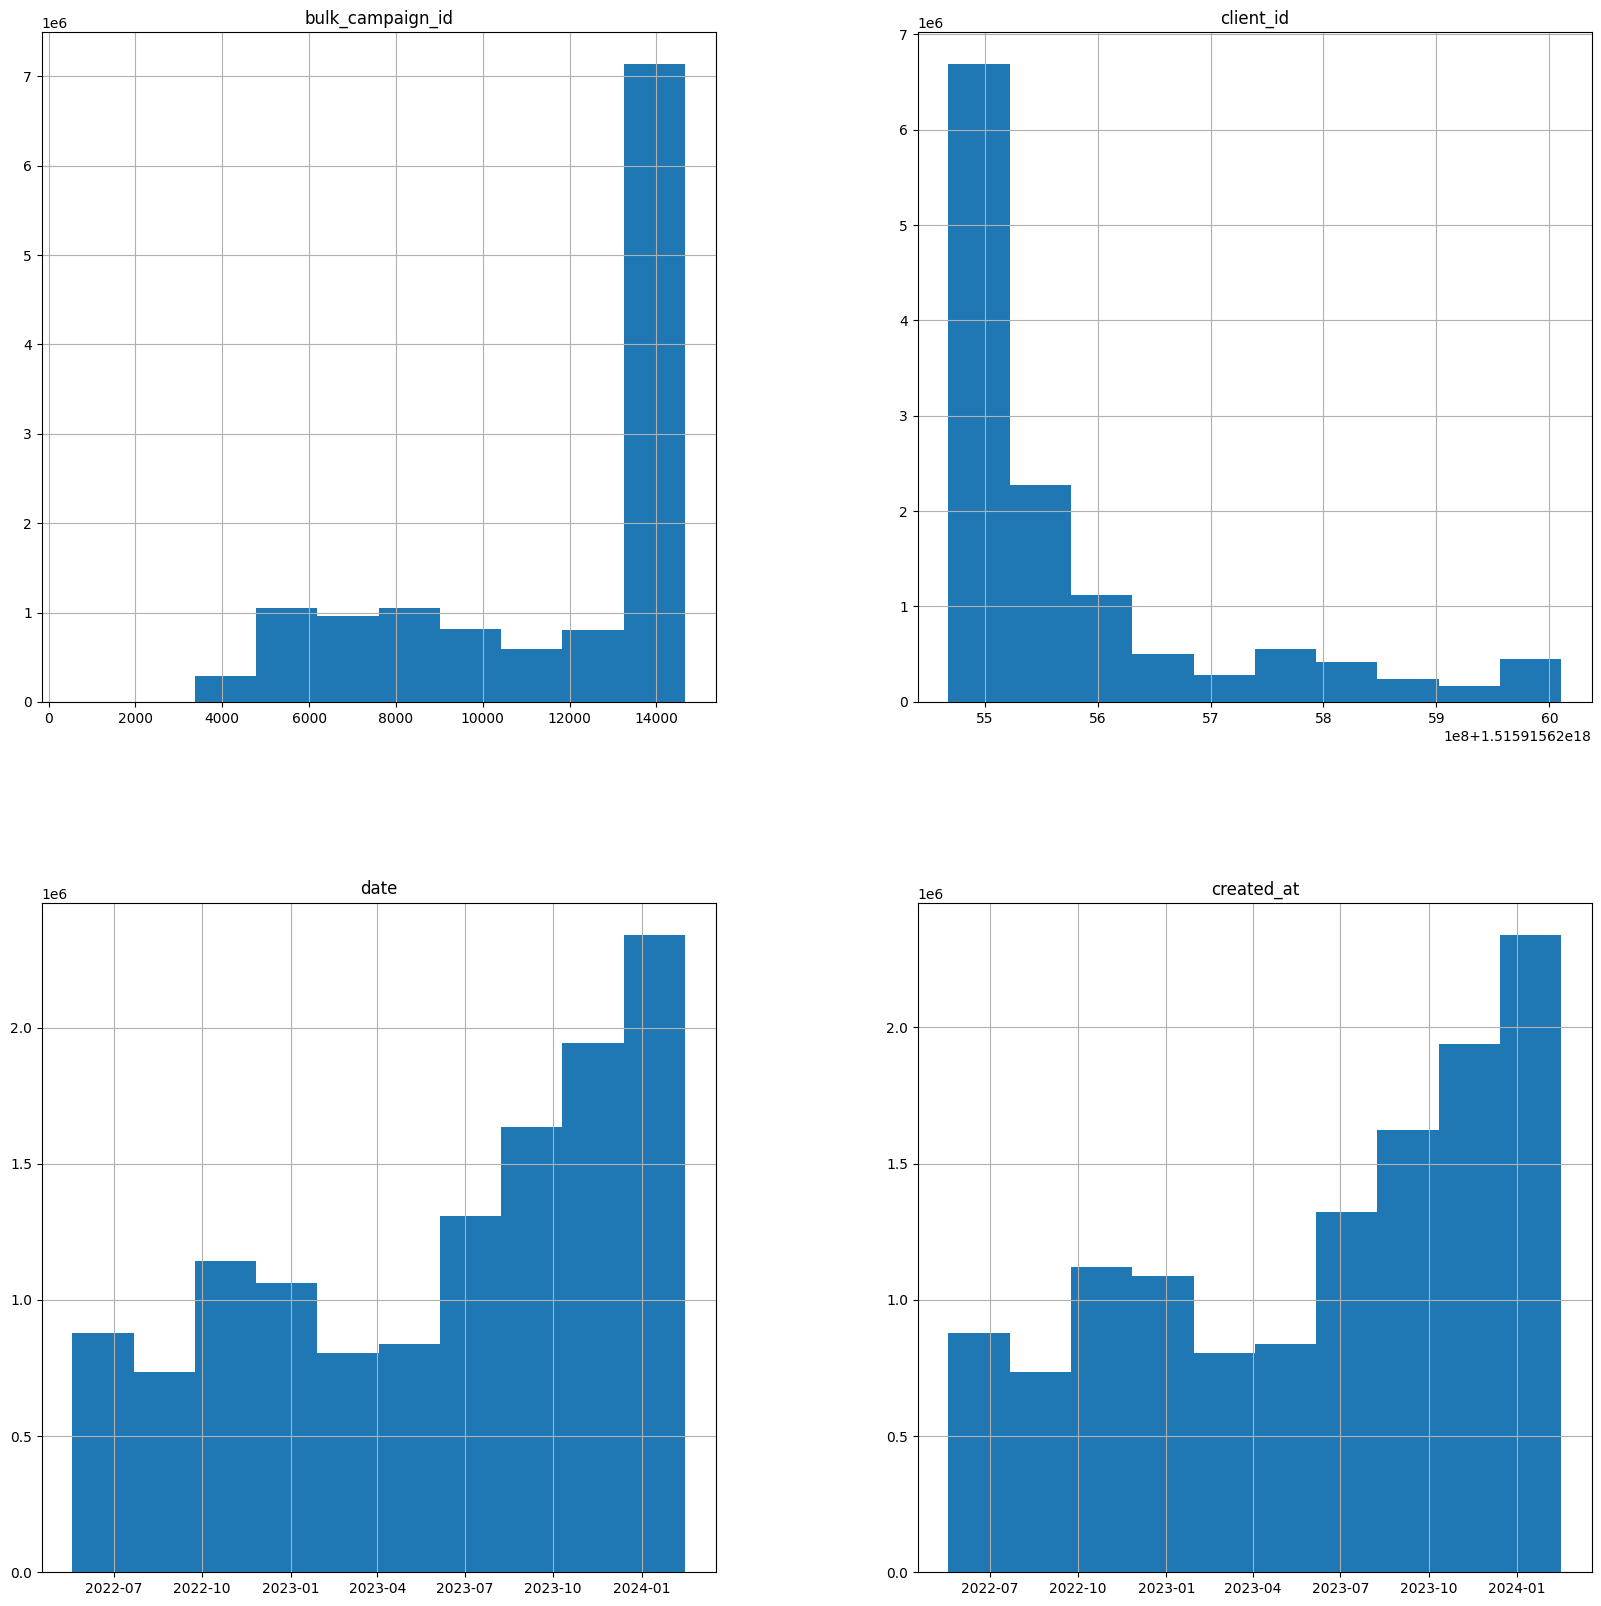

In [49]:
messages.hist(figsize=(20, 20))
plt.show()

In [50]:
display(messages['event'].value_counts())
display(messages['channel'].value_counts())

event
send           9058174
open           3052481
click           483326
purchase         62593
hard_bounce      19763
soft_bounce      10582
unsubscribe       2833
hbq_spam           823
complain           527
subscribe           85
close                1
Name: count, dtype: int64

channel
mobile_push    7470472
email          5220716
Name: count, dtype: int64

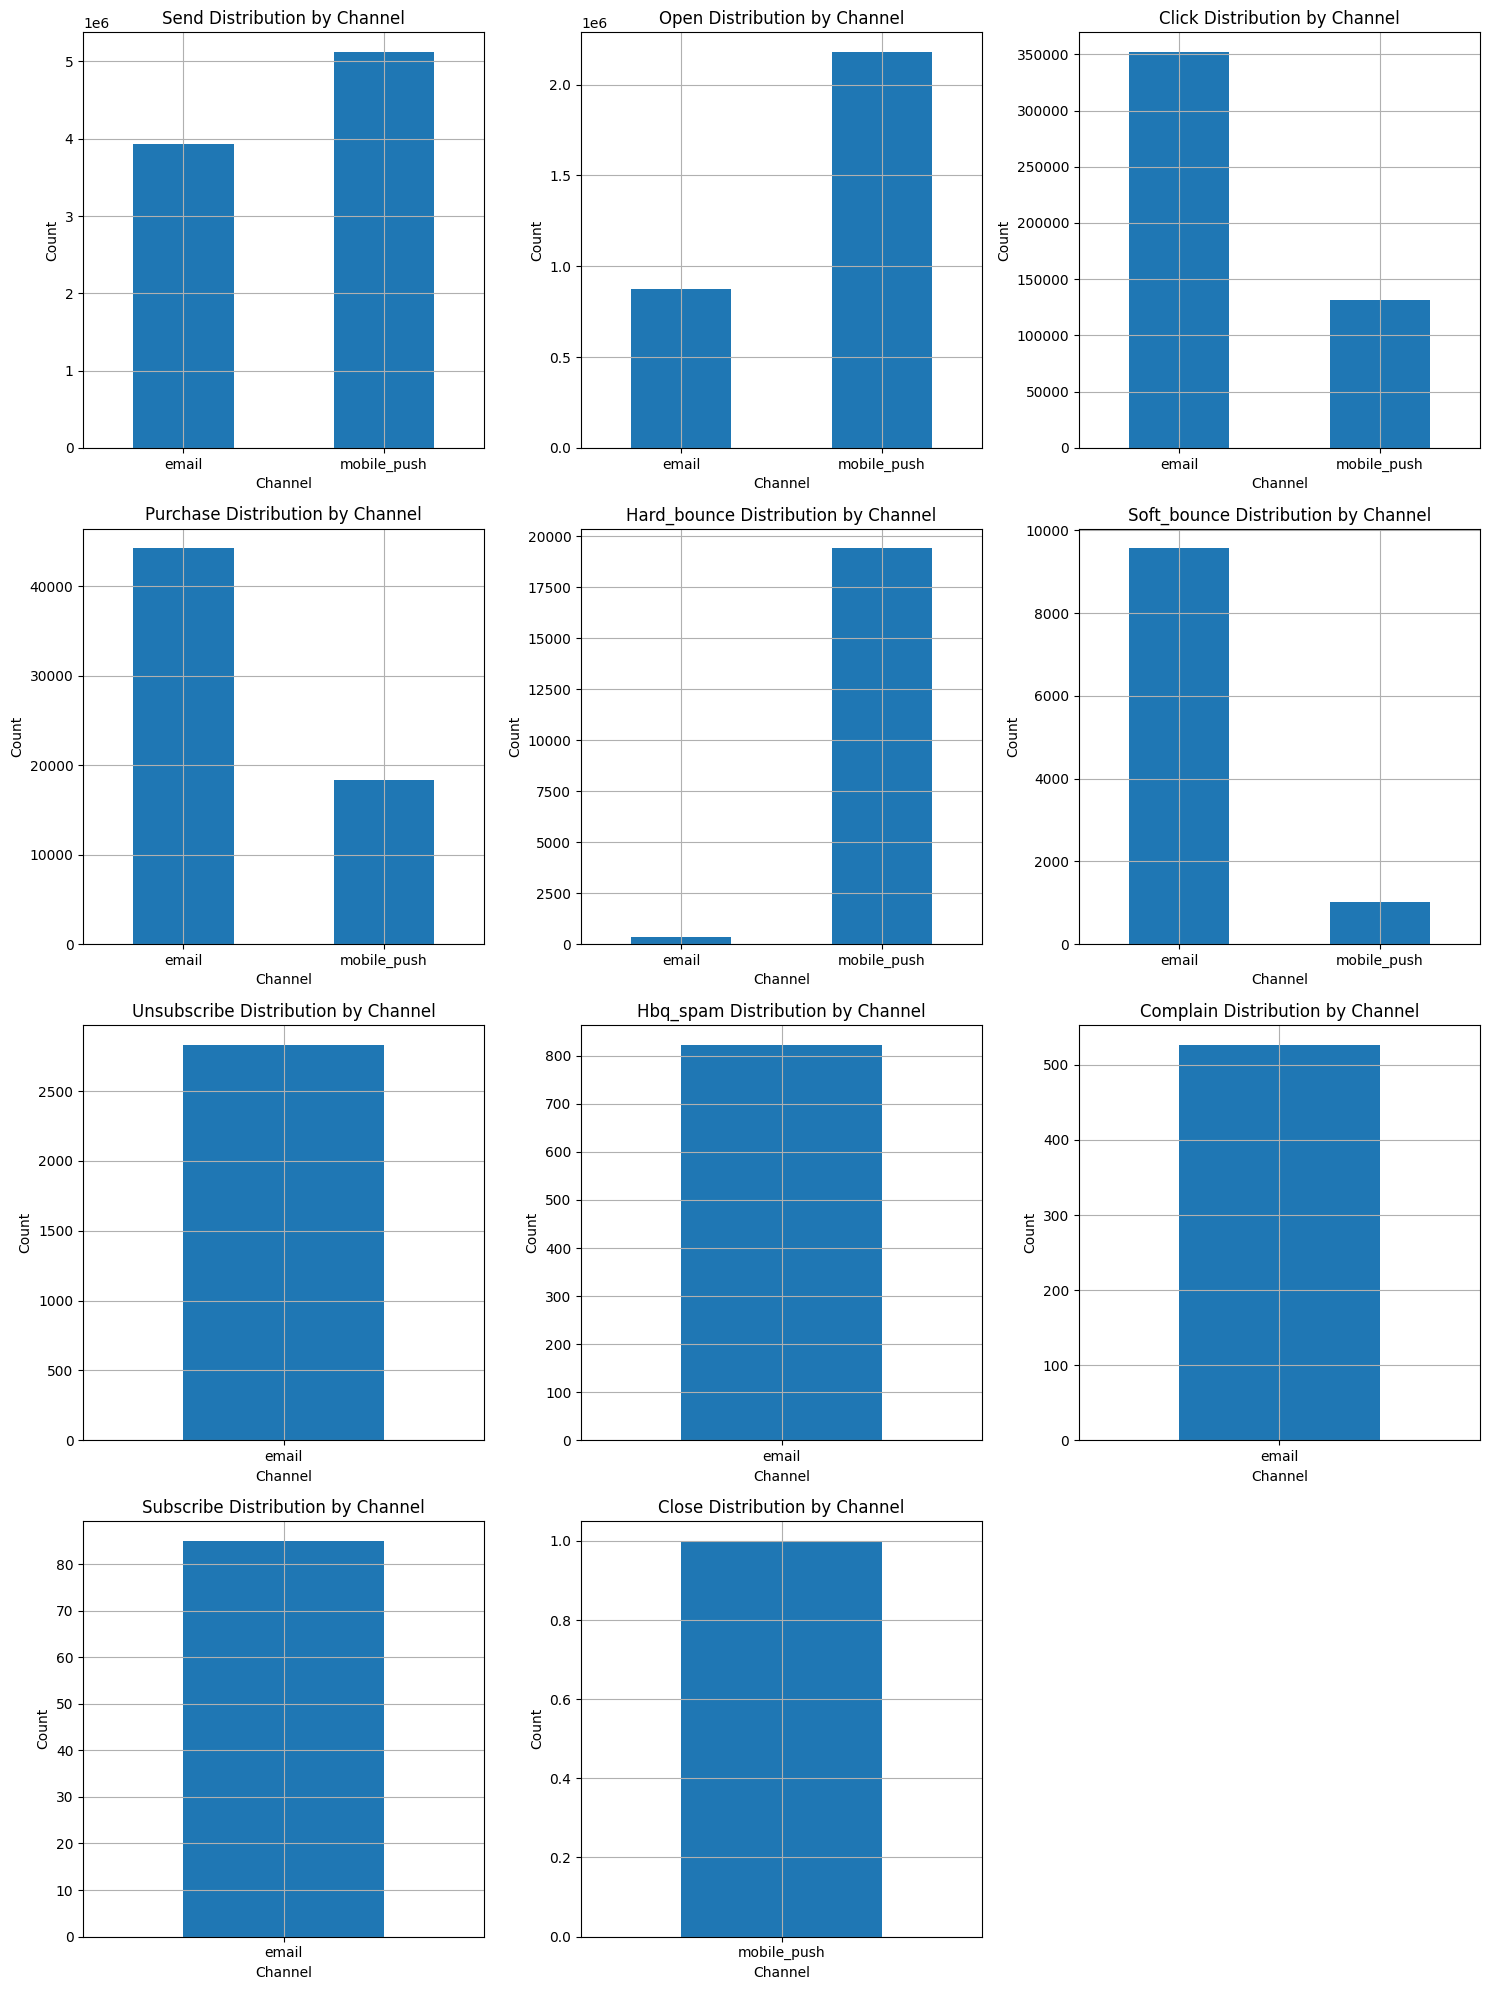

In [51]:
events_list = ['send', 'open', 'click', 'purchase', 'hard_bounce', 
               'soft_bounce', 'unsubscribe', 'hbq_spam', 'complain', 'subscribe', 'close']
plot_events_by_channel(events_list, messages)

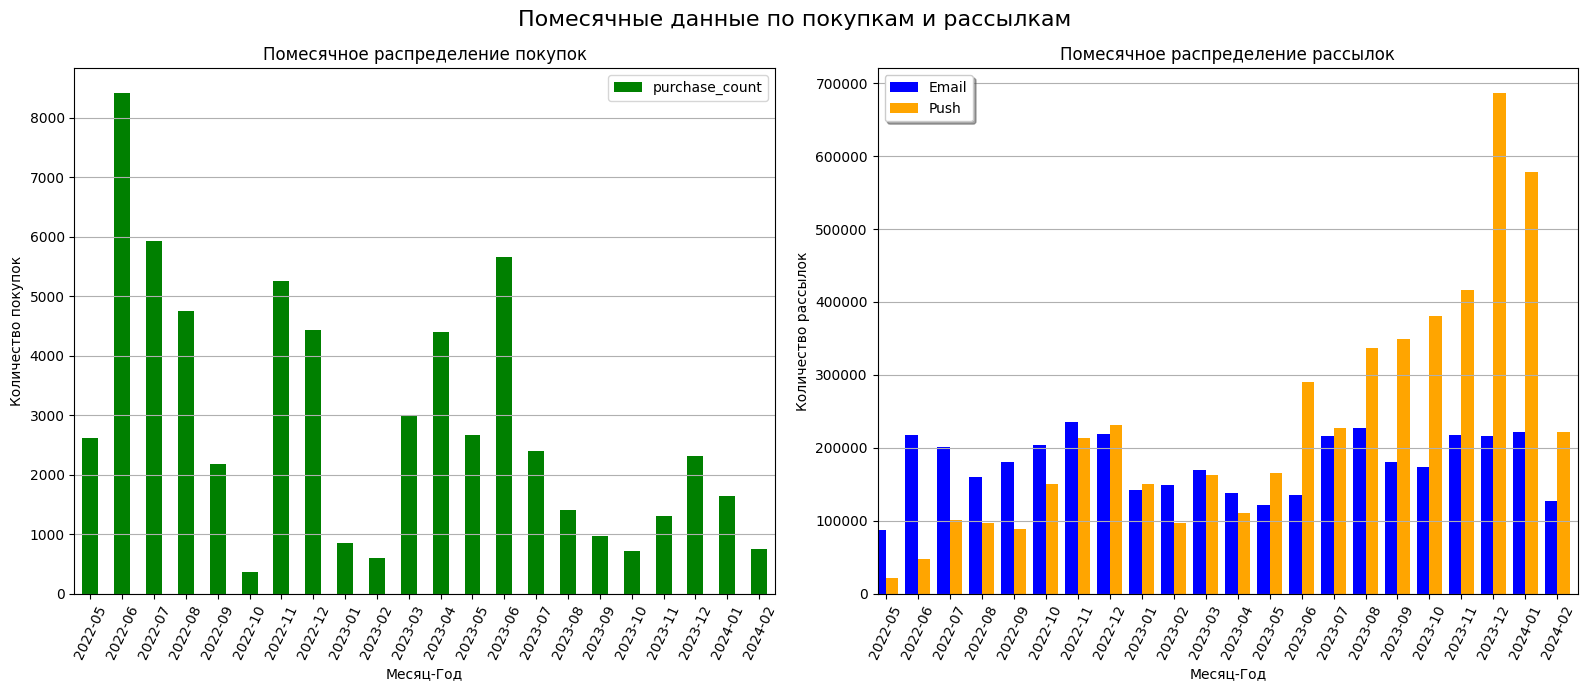

In [52]:
mes_purchases = messages.query("event == 'purchase'")
sends = messages.query("event == 'send'")

mes_purchases['month_year'] = mes_purchases['date'].dt.strftime('%Y-%m')
sends['month_year'] = sends['date'].dt.strftime('%Y-%m')

monthly_purchases = mes_purchases.groupby('month_year').size().reset_index(name='purchase_count')

sends['is_email'] = sends['channel'] == 'email'
sends['is_mobile_push'] = ~sends['is_email']

monthly_emails = sends[sends['is_email']]
monthly_mobile_pushes = sends[sends['is_mobile_push']]
emails_grouped = monthly_emails.groupby('month_year').size().reset_index(name='email_send_count')
pushes_grouped = monthly_mobile_pushes.groupby('month_year').size().reset_index(name='push_send_count')


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Первый график: Покупки
monthly_purchases.plot(x='month_year', y='purchase_count', kind='bar', ax=ax1, color='green')
ax1.set_title('Помесячное распределение покупок')
ax1.set_xlabel('Месяц-Год')
ax1.set_ylabel('Количество покупок')
ax1.tick_params(axis='x', rotation=65)
ax1.grid(axis='y')

# Второй график: Рассылки
width = 0.4  
emails_grouped.plot(x='month_year', y='email_send_count', kind='bar', ax=ax2, position=1, width=width, color='blue', label='Email')
pushes_grouped.plot(x='month_year', y='push_send_count', kind='bar', ax=ax2, position=0, width=width, color='orange', label='Push')

ax2.set_title('Помесячное распределение рассылок')
ax2.set_xlabel('Месяц-Год')
ax2.set_ylabel('Количество рассылок')
ax2.tick_params(axis='x', rotation=65)
ax2.grid(axis='y')
ax2.legend(loc='upper left', shadow=True, labels=['Email', 'Push'])


fig.suptitle('Помесячные данные по покупкам и рассылкам', fontsize=16)
plt.tight_layout()
plt.show()

**Кратко по messages:**

1. Изучили способы коммуникации: Мейл и пуши;

2. Изучили список действий в коммуникациях и их распределение между пушами и мейлом. Из интересного можно выделить следующее: открывают чаще пуш-уведомление, а не рассылку. (логично). Покупки, как и клики чаще проходят через почту. Жесткое отклонение почти всегда в пушах. Мягкое отклонение наоборот практически всегда проходило по почте. Soft Bounce – это термин в email маркетинге, который описывает ситуацию, когда электронное письмо временно не может быть доставлено на почтовый ящик получателя. В отличие от hard bounce, где проблема постоянна и необратима Остальные варианты были только на почте или наоборот только в пушах (закрытие) и их всего около 4к записей на 5 категорий.

3. Так как таргетом является покупка, изучили в какие месяцы больше всего покупок осуществлялось после рассылки. Лето, особенно июнь заслужено забирает первое место по покупкам (хотя я каа-то давно читал, что лето наоборот пора затишья в продажах, так как летом все в отпусках просто гуляют). Аутсайдерами стали октябрь 22 года (да и 23 тоже). В целом прослеживается потеря интереса в холодное время года за исключеним ноября и декбабр 22 года.

4. Сразу же вывели и кол-во рассылок по месяцам. Это в какой-то степени будет отражать то, как кол-во рассылок влияло на покупку в конкретном месяце. Например: в октябре 22 года было ~400 покупок несмотря на то, что в это время было далеко не маленькое кол-во рассылок: более ~350к  из которых  200к это мейлы и порядка 150к это пуши.


___

In [55]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


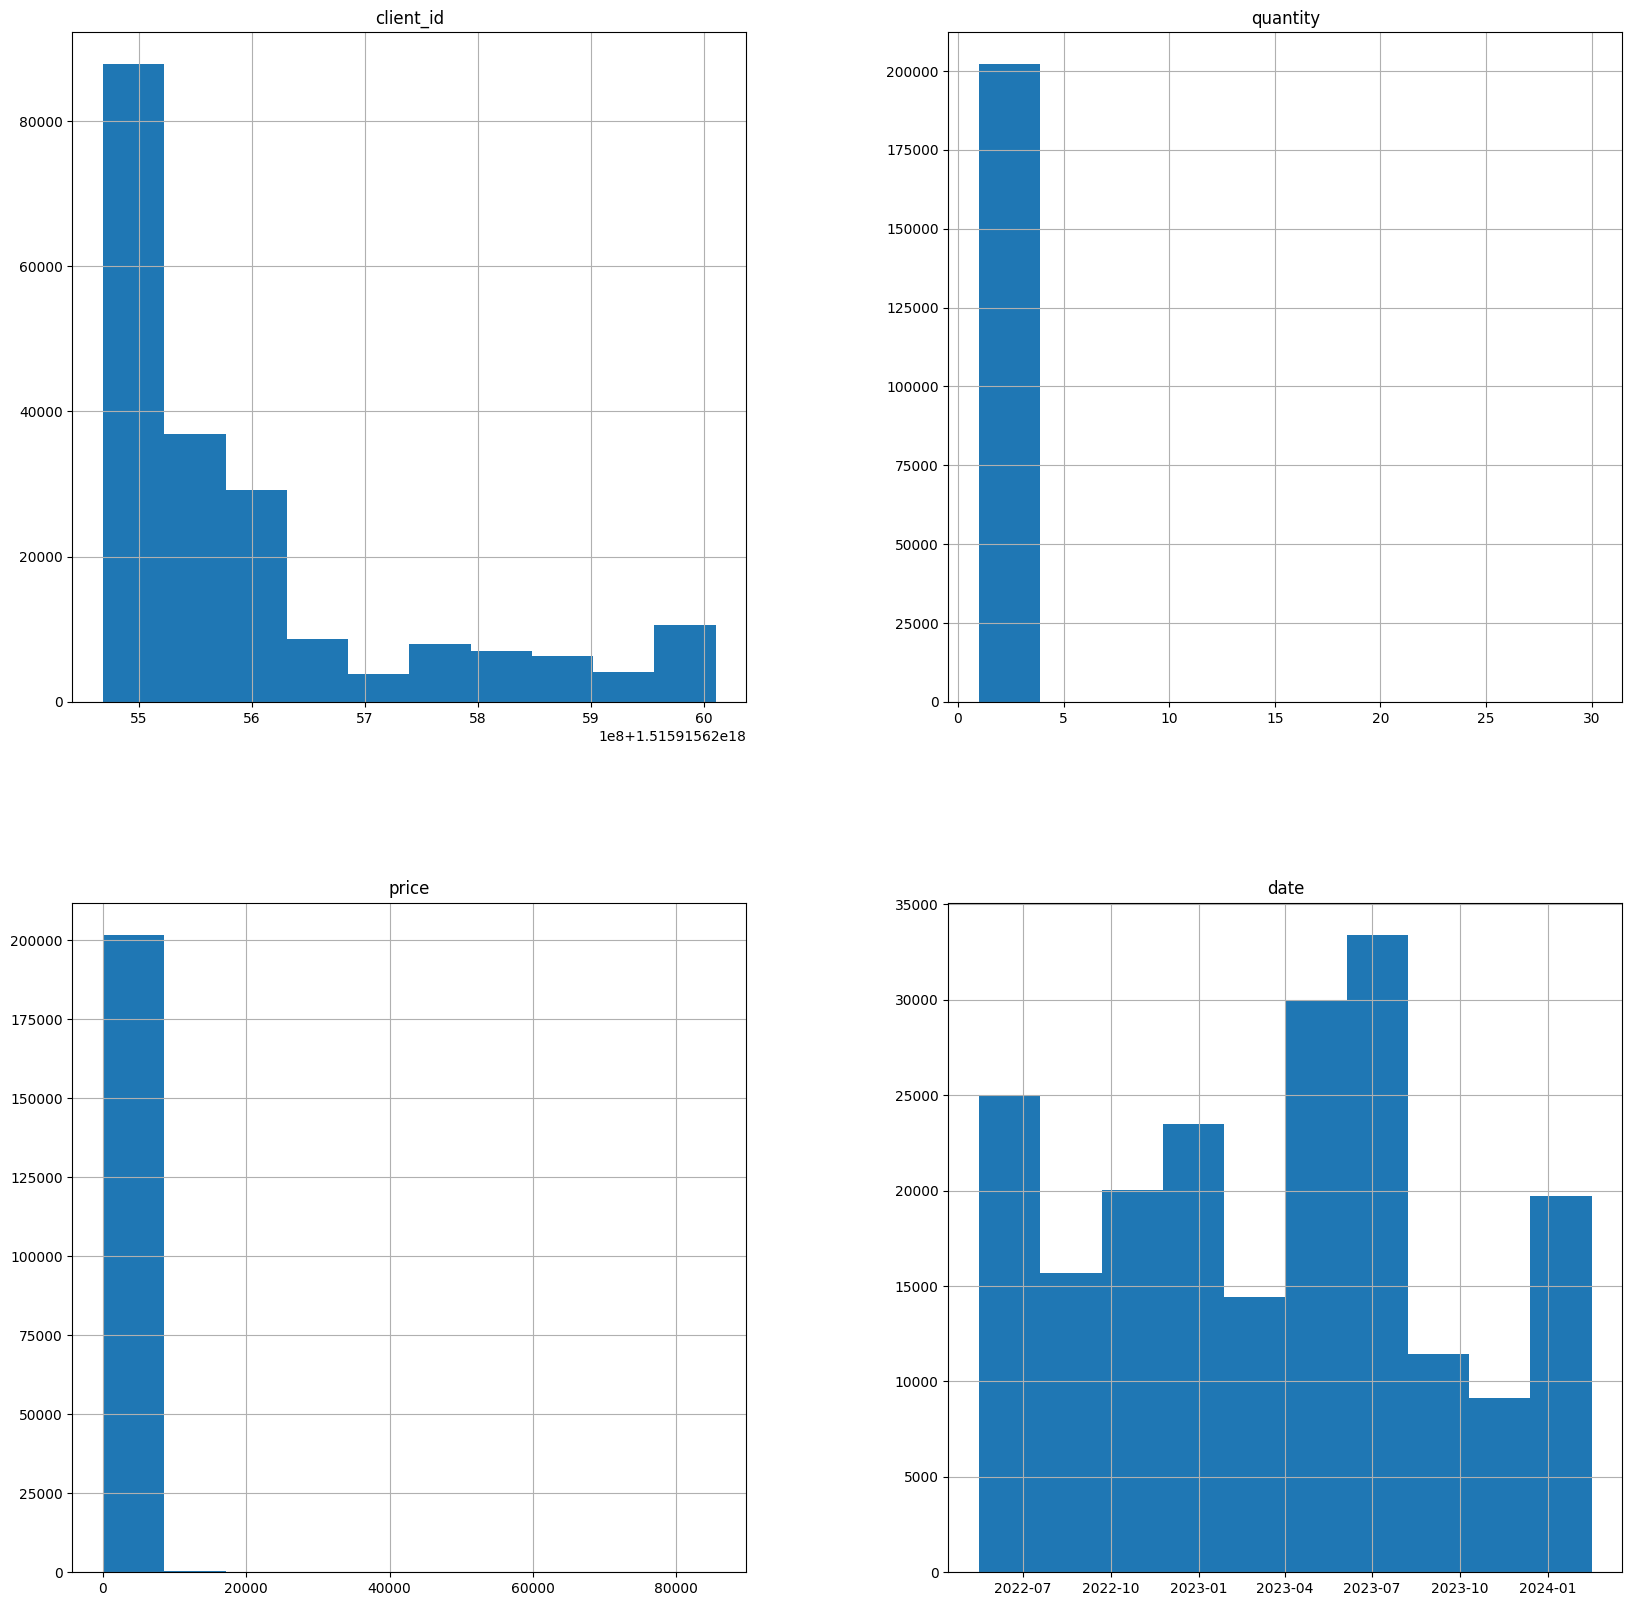

In [56]:
purchases.hist(figsize=(20, 20))
plt.show()

In [57]:
display(purchases['quantity'].value_counts())
display(purchases['category_ids'].value_counts())

quantity
1     201323
2        751
3         94
4         12
6          5
10         4
20         3
15         3
5          3
25         2
30         2
9          2
13         1
18         1
8          1
7          1
Name: count, dtype: int64

category_ids
['4', '28', '57', '431']            8626
['4', '28', '260', '420']           6989
['4', '28', '244', '432']           6821
[]                                  5579
['4', '28', '275', '421']           4936
                                    ... 
['4', '5837', '5836', '839']           1
['5562', '5632', '5552', '1089']       1
['4', '27', '278', '471']              1
['5562', '5697', '5651', '1153']       1
['5562', '5597', '5696', '5529']       1
Name: count, Length: 933, dtype: int64

In [58]:
purchases['category_ids'] = purchases['category_ids'].apply(ast.literal_eval)

In [59]:
purchases['last_category'] = purchases['category_ids'].str[-1]

In [60]:
purchases.sample(n=6)

,client_id,quantity,price,category_ids,date,message_id,last_category
25724,1515915625500510371,1,1699.0,"[2, 18, 344, 445]",2022-07-22,1515915625500510371-5515-62d79a0b58d55,445
109878,1515915625958683458,1,599.0,"[5562, 5630, 5659, 607]",2023-04-27,1515915625952658046-12224-644a86482e7a0,607
168176,1515915625475341445,1,1799.0,"[4, 28, 146, 548]",2023-09-08,1515915625475341445-13779-64fac56e833f3,548
89679,1515915625579930946,1,2499.0,"[4, 28, 218, 652]",2023-03-06,1515915625559875993-10671-6405d108a2129,652
14163,1515915625768841055,1,2999.0,"[4, 28, 249, 616]",2022-06-16,1515915625768841055-4962-62aae6a25ecbb,616
174493,1515915625559377428,1,399.0,"[4, 27, 84, 515]",2023-10-27,1515915625535966195-13982-6532374f40a17,515


In [61]:
mask = purchases['last_category'].value_counts() < 50
filtered_categories = purchases['last_category'].value_counts().loc[mask]
display(filtered_categories)

last_category
799     49
5803    49
1705    49
589     48
765     47
        ..
1727     1
1429     1
5950     1
1775     1
1579     1
Name: count, Length: 464, dtype: int64

mask = purchases['last_category'].isin(filtered_categories.index)
count = mask.sum()
print(f'Количество строк, соответствующих условию: {count}')

In [63]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   client_id      202208 non-null  int64         
 1   quantity       202208 non-null  int64         
 2   price          202208 non-null  float64       
 3   category_ids   202208 non-null  object        
 4   date           202208 non-null  datetime64[ns]
 5   message_id     202208 non-null  object        
 6   last_category  195365 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 10.8+ MB


In [64]:
missing = purchases[purchases['last_category'].isna()]
missing.sample(n=3)

,client_id,quantity,price,category_ids,date,message_id,last_category
178914,1515915625964153916,1,7.0,[],2023-11-13,1515915625964153916-14099-655099b9406be,NaN
84083,1515915625548094865,1,6.0,[],2023-01-27,1515915625548094865-9630-63d3810ee27a6,NaN
100896,1515915625477701622,1,7.0,[],2023-04-12,1515915625477701622-11760-64367406ede2e,NaN


In [65]:
purchases.dropna(subset=['last_category'], inplace=True)
purchases['last_category'] = purchases['last_category'].astype(int)

In [66]:
purchases.sample(n=3)

,client_id,quantity,price,category_ids,date,message_id,last_category
159379,1515915625587586305,1,219.0,"[4, 28, 290, 422]",2023-07-13,1515915625490181622-13482-64ae72408f0fb,422
74802,1515915625558327949,1,350.0,"[5562, 5631, 5648, 508]",2022-12-22,1515915625558327949-8902-63a2cef90aeb4,508
197009,1515915625574513478,1,1049.0,"[4, 28, 104, 429]",2024-01-25,1515915625574513478-14482-65a6379ebb87e,429


In [67]:
# Определяем границы категорий
categories = [
    (1, 5, 'rare'),
    (6, 10, 'infrequent'),
    (11, 50, 'moderate'),
    (51, 100, 'frequent'),
    (101, 250, 'popular'),
    (251, 500, 'trendy'),
    (501, 1000, 'hit'),
    (1001, 2000, 'bestseller'),
    (2001, 5000, 'top'),
    (5001, 10000, 'blockbuster')
]

In [68]:
purchases['popularity'] = purchases.apply(get_popularity, axis=1)

In [69]:
purchases['popularity'].value_counts()

popularity
top            48554
bestseller     39446
hit            26592
blockbuster    22436
trendy         22364
popular        19334
frequent        7889
moderate        7825
infrequent       624
rare             301
Name: count, dtype: int64

In [70]:
purchases['month_year'] = purchases['date'].dt.strftime('%Y-%m')
purchases['year'] = purchases['date'].dt.year
purchases['month'] = purchases['date'].dt.month

<Figure size 1000x600 with 0 Axes>

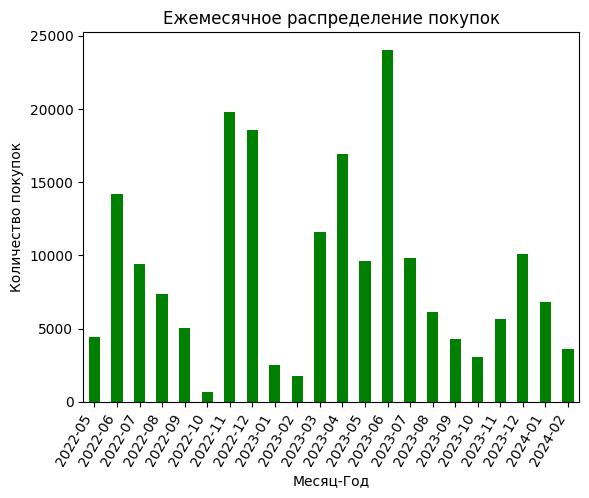

<Figure size 1000x600 with 0 Axes>

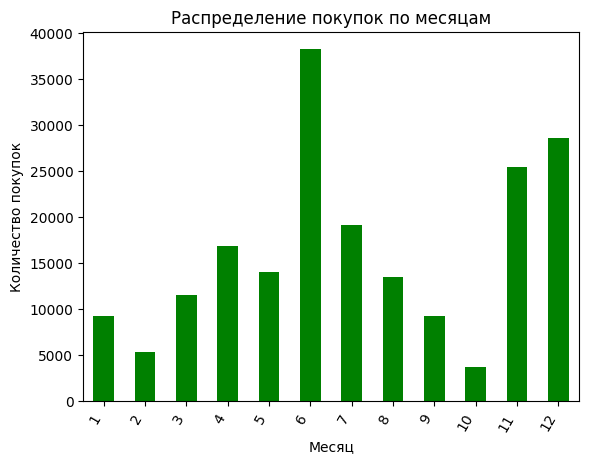

<Figure size 1000x600 with 0 Axes>

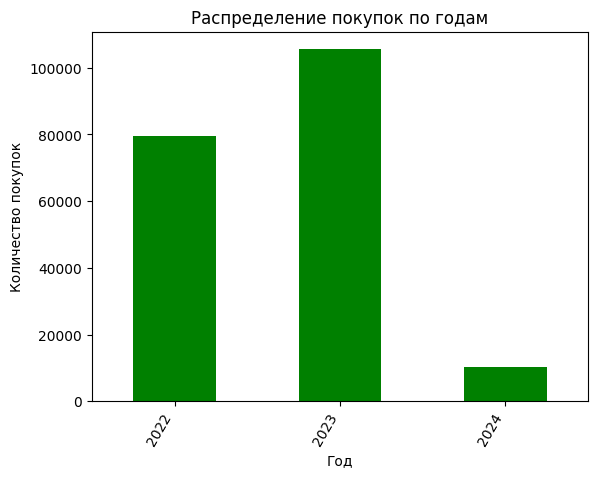

In [71]:
plot_purchases(purchases, 'month_year', 'Ежемесячное распределение покупок', 'Месяц-Год', 'Количество покупок')
plot_purchases(purchases, 'month', 'Распределение покупок по месяцам', 'Месяц', 'Количество покупок')
plot_purchases(purchases, 'year', 'Распределение покупок по годам', 'Год', 'Количество покупок')

In [72]:
purchases['price'].describe()

count    195365.000000
mean       1233.400768
std        1341.477942
min           1.000000
25%         399.000000
50%         999.000000
75%        1728.000000
max       85499.000000
Name: price, dtype: float64

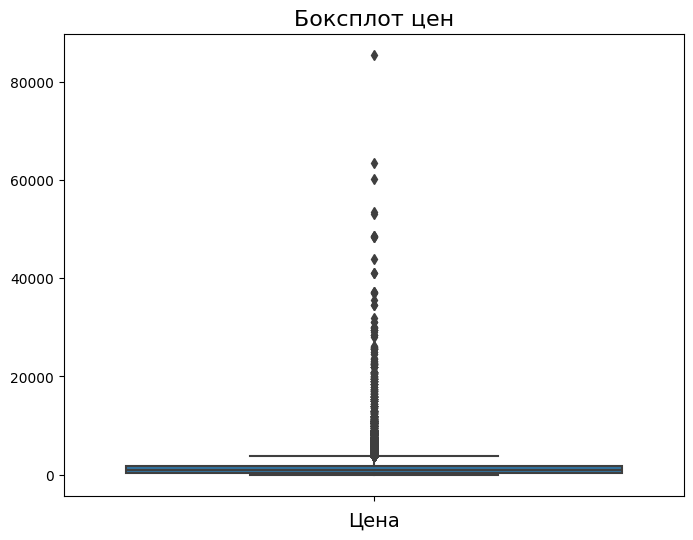

In [73]:
plt.figure(figsize=(8, 6))
sns.boxplot(y=purchases['price'], orient='h')
plt.title('Боксплот цен', fontsize=16)
plt.xlabel('Цена', fontsize=14)
plt.ylabel('')
plt.show()

In [74]:
filtered_df = purchases.query("price > 20000")
filtered_df.reset_index(drop=True, inplace=True)
filtered_df['popularity'].value_counts()

popularity
frequent      51
moderate      27
infrequent     4
Name: count, dtype: int64

In [75]:
purchases = purchases[purchases['price'] < 20000]

In [76]:
filtered_df = purchases.query("price > 3800")
filtered_df.reset_index(drop=True, inplace=True)
filtered_df['popularity'].value_counts()

popularity
top            2987
bestseller     1016
hit             590
blockbuster     448
moderate        396
frequent        328
popular         302
trendy          299
infrequent       13
rare              8
Name: count, dtype: int64

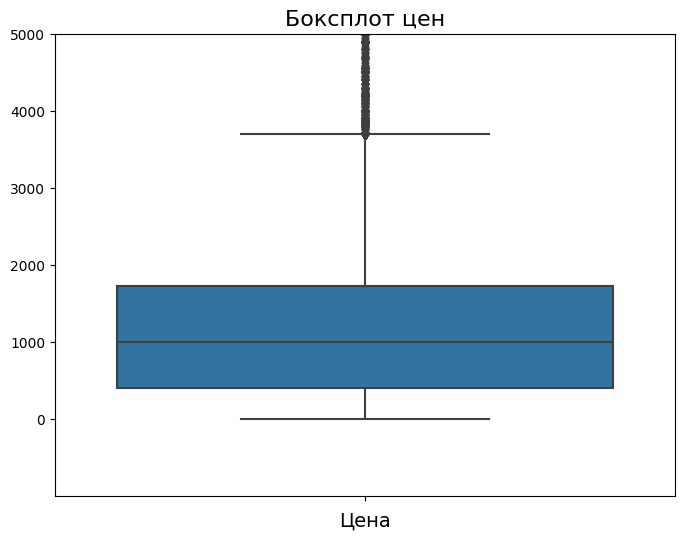

In [77]:
plt.figure(figsize=(8, 6))
sns.boxplot(y=purchases['price'], orient='h')
plt.title('Боксплот цен', fontsize=16)
plt.xlabel('Цена', fontsize=14)
plt.ylabel('')
plt.ylim(top=5000)
plt.show()

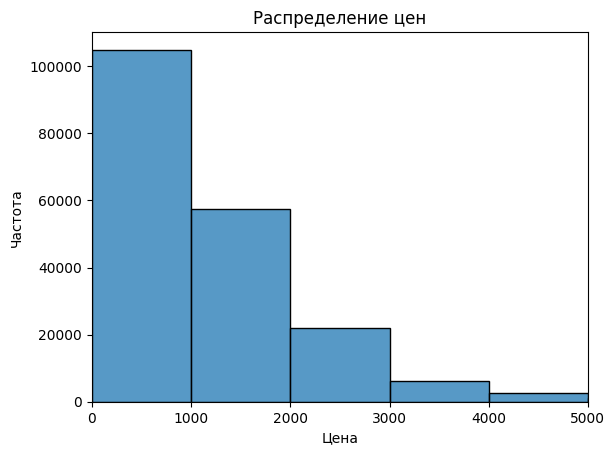

In [78]:
sns.histplot(purchases['price'], bins=20)
plt.title('Распределение цен')
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.xlim(0, 5000)
plt.show()

In [79]:
purchases['price'].describe()

count    195283.000000
mean       1221.431046
std        1184.717192
min           1.000000
25%         399.000000
50%         999.000000
75%        1718.000000
max       19999.000000
Name: price, dtype: float64

In [80]:
purchases.head(n=2)

,client_id,quantity,price,category_ids,date,message_id,last_category,popularity,month_year,year,month
0,1515915625468169594,1,1999.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,431,blockbuster,2022-05,2022,5
1,1515915625468169594,1,2499.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,431,blockbuster,2022-05,2022,5


In [81]:
messages.head(n=2)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34


**Кратко по purchases:**
1. Практически всегда приобретается по 1 товару. Есть парочка заказов на 30 товаров (!!!)
2. С категориями очень непросто: Создали новую колонку, в которой отражается последняя категория из списка в колонке **category_ids**. Что нам это дает? Логично, что покупка совершалась именно по последней категории в которую провалился. Также у нас есть 7к строк с нулевой информацией о категории покупки. Учитывая объем датасета можем смело сносить их. Нет смысла заполнять строки заглушками. Также было принято решение разбить категории по популярности, так, например 464 категории товаров (то есть половина от всего кол-ва) по которым было не более 50 покупок. Таким образом удалось сильно укрупнить данные до 10 вариантов.
3. Изучили покупки по датам. Глянули как проходили покупки в отдельные годы и месяца, а также по месяцам в конкретном году.  24 год был не полным, поэтому естественно в нем мало покупок. 22 год также был не полным, а лишь с 5 месяца... Не очень показательно конечно. По дням что либо смотреть не вижу смысла.
4. По цене есть несколько покупок на 20+к, но их меньше 100. Это аномальные значения вразрезе датасета, поэтому снесм такие данные. Так в среднем покупка составляла по 1221 руб, медиана составила 999 руб, а лишь 25% покупок превышали 1718 руб.  

___

In [84]:
target_binary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


In [85]:
target_binary.head() 

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


**Кратко по target_binary:**
 - Тут нечего абсолютно рассказывать)

___

In [88]:
campaign_daily_event.head(n=3)

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
0,2022-05-19,563,0,0,0,4,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0


In [89]:
campaign_daily_event['year'] = campaign_daily_event['date'].dt.year
campaign_daily_event['month'] = campaign_daily_event['date'].dt.month

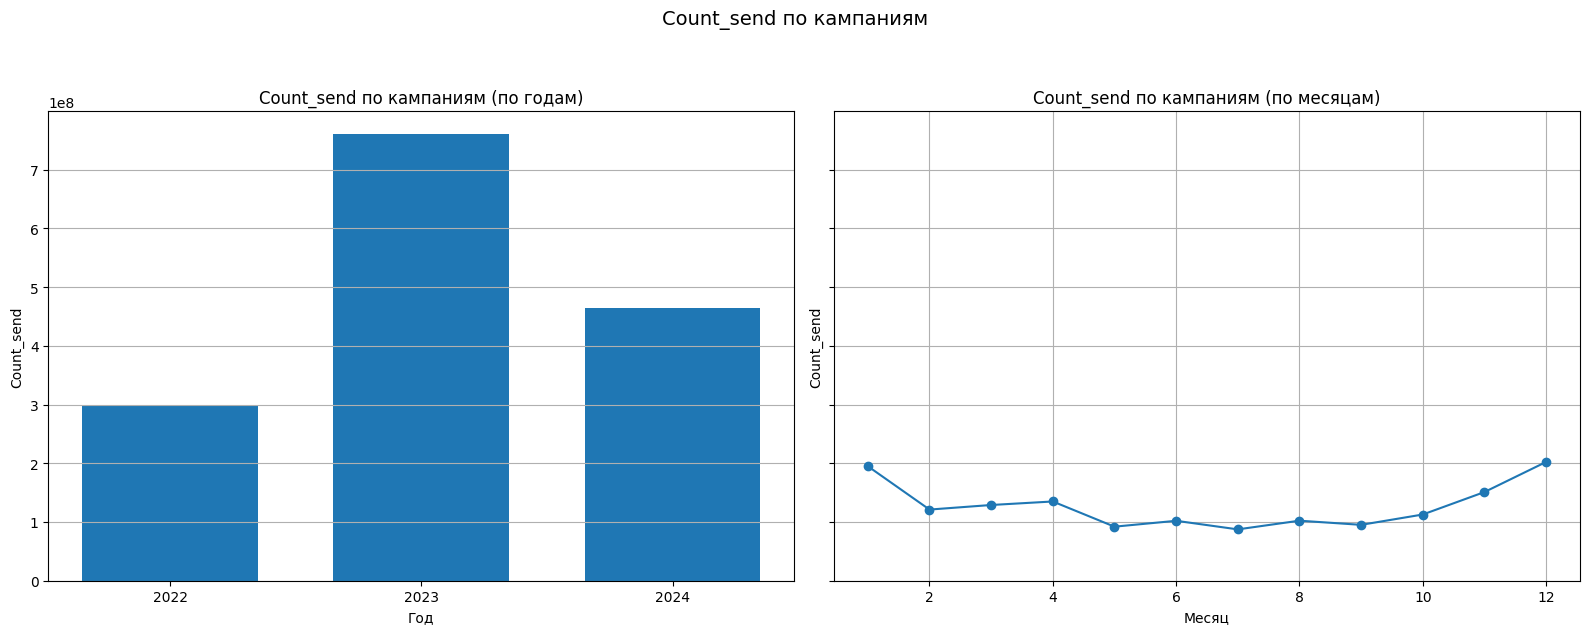

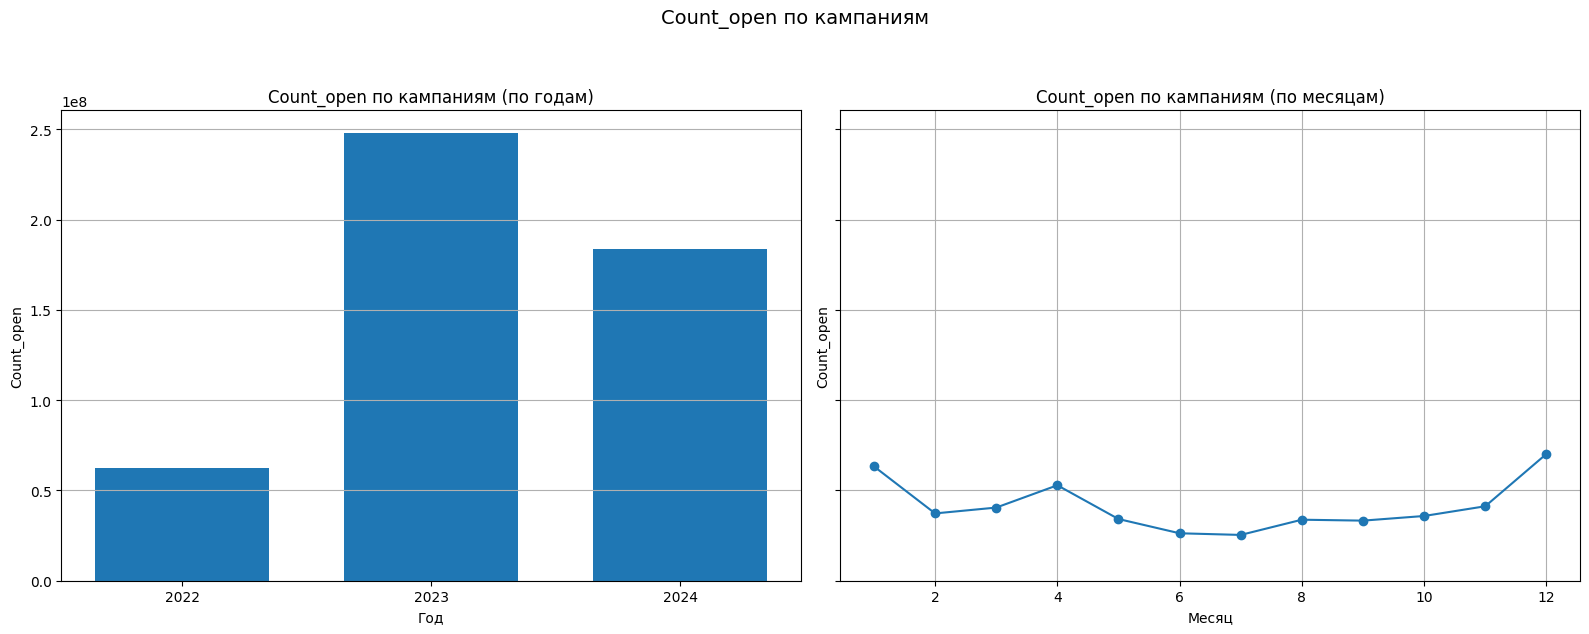

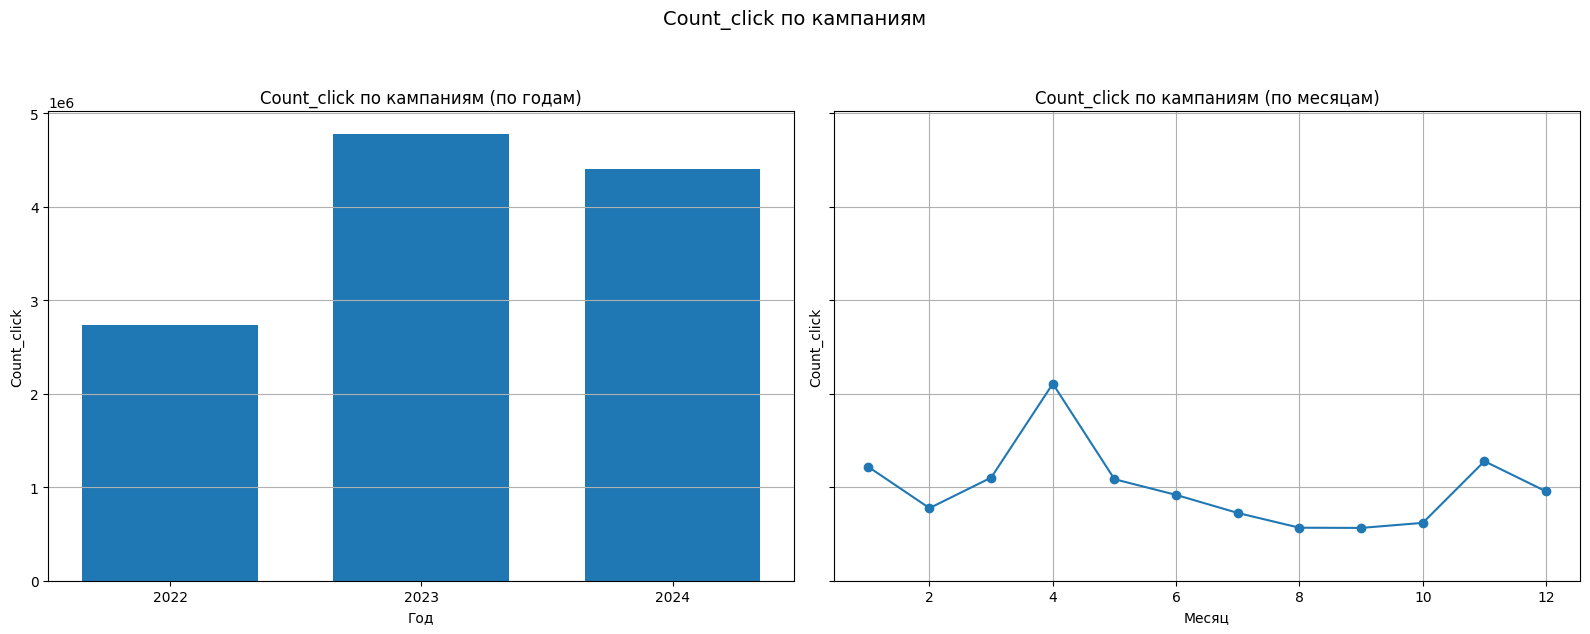

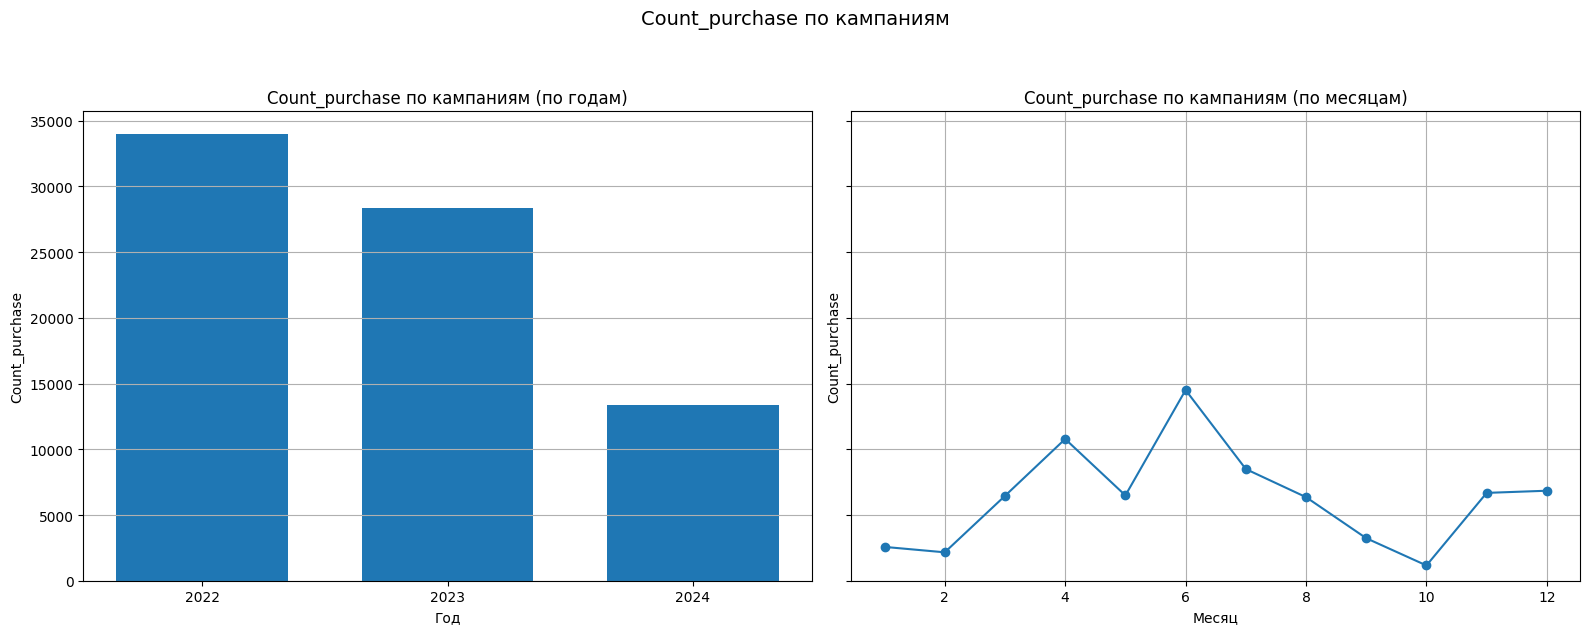

In [90]:
columns_to_plot = ['count_send', 'count_open', 'count_click', 'count_purchase']
for column in columns_to_plot:
    plot_column_by_year_and_month(campaign_daily_event, column)

**Коротко по campaign_daily_event:**

В этом датасете глянули всего несколько колонок: кол-во отправленных писем, кол-вот открытий; кол-во кликов и, конечно же, покупка. Смотрели данные в разрезе лет и месяцев. Если честно, то информация будто бы не очень полезная, непонятно как она мне поможет. Есть предположение, что стоит найти ту самую успешную рекламную кампанию. Также найдем плохую маркетинговую кампанию. Думаю это лучше всего будет сделать  высчитав соотношение отправленных, открытых, кликнутых сообщений, которые закончились покупкой. Так мы будем видеть в процентном соотношении успешность воронки продаж. Далее, как вариант, можно будет сделать новый признак: кампания была успешной\неуспешной\нейтральной.  (сделали колонку campaign_success)      

___

In [93]:
campaign_daily_event_channel['date'] = campaign_daily_event_channel['date'].dt.strftime('%Y-%m')
campaign_daily_event_channel['year'] = pd.to_datetime(campaign_daily_event_channel['date']).dt.year
campaign_daily_event_channel['month'] = pd.to_datetime(campaign_daily_event_channel['date']).dt.month

In [94]:
top_10_best_email = campaign_daily_event_channel.groupby('bulk_campaign_id')['count_purchase_email'].sum().sort_values(ascending=False).head(10)
top_10_worst_email = campaign_daily_event_channel.groupby('bulk_campaign_id')['count_purchase_email'].sum().sort_values(ascending=True).head(10)

top_10_best_push = campaign_daily_event_channel.groupby('bulk_campaign_id')['count_purchase_mobile_push'].sum().sort_values(ascending=False).head(10)
top_10_worst_push = campaign_daily_event_channel.groupby('bulk_campaign_id')['count_purchase_mobile_push'].sum().sort_values(ascending=True).head(10)

In [95]:
display(pd.DataFrame({'Top 10 Best Email': top_10_best_email}))
display(pd.DataFrame({'Top 10 Worst Email': top_10_worst_email}))
display(pd.DataFrame({'Top 10 Best Mobile Push': top_10_best_push}))
display(pd.DataFrame({'Top 10 Worst Mobile Push': top_10_worst_push}))

,Top 10 Best Email
bulk_campaign_id,
4679,2494
12218,1525
5335,1337
7803,1259
13157,1158
4744,1103
4492,1050
4710,966
8902,944


,Top 10 Worst Email
bulk_campaign_id,
548,0
13886,0
13888,0
13889,0
13890,0
13891,0
13892,0
13894,0
13895,0


,Top 10 Best Mobile Push
bulk_campaign_id,
15028,801
15032,572
14081,519
13324,420
8725,359
5254,355
13319,348
14917,318
8813,316


,Top 10 Worst Mobile Push
bulk_campaign_id,
548,0
13419,0
13417,0
13411,0
13406,0
13404,0
13399,0
13398,0
13392,0


In [96]:
# Исключаем нулевые значения
non_zero_purchases_email = campaign_daily_event_channel.query("count_purchase_email != 0")['count_purchase_email']

# Рассчитываем среднее арифметическое
mean_purchases_email = non_zero_purchases_email.mean()

In [97]:
campaign_daily_event_channel['campaign_success'] = campaign_daily_event_channel.apply(classify_campaign, axis=1)

In [98]:
# Агрегирование данных по bulk_campaign_id
aggregated_data = campaign_daily_event_channel.groupby('bulk_campaign_id').agg({
    'count_purchase_email': 'sum',
    'count_purchase_mobile_push': 'sum'
})

# Поиск кампаний, которые не привели к покупкам по email
no_purchases_email = aggregated_data.query("count_purchase_email == 0").shape[0]

# Поиск кампаний, которые не привели к покупкам по mobile push
no_purchases_push = aggregated_data.query("count_purchase_mobile_push == 0").shape[0]

print(f"Количество bulk_campaign_id, которые не привели к покупкам по email: {no_purchases_email}")
print(f"Количество bulk_campaign_id, которые не привели к покупкам по mobile push: {no_purchases_push}")

Количество bulk_campaign_id, которые не привели к покупкам по email: 2750
Количество bulk_campaign_id, которые не привели к покупкам по mobile push: 1717


In [99]:
len(campaign_daily_event_channel['bulk_campaign_id'].unique())

3181

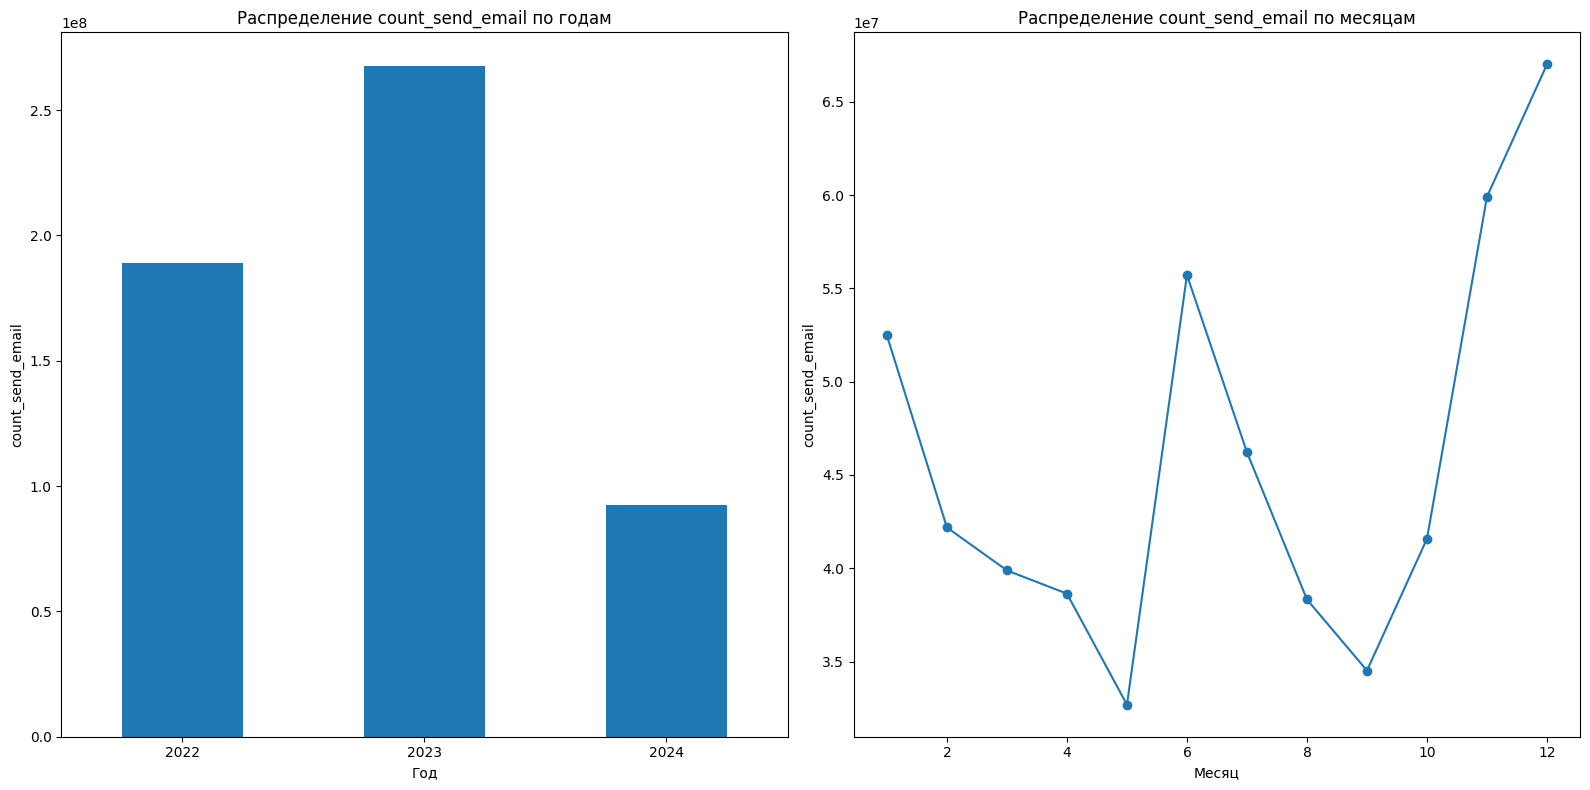

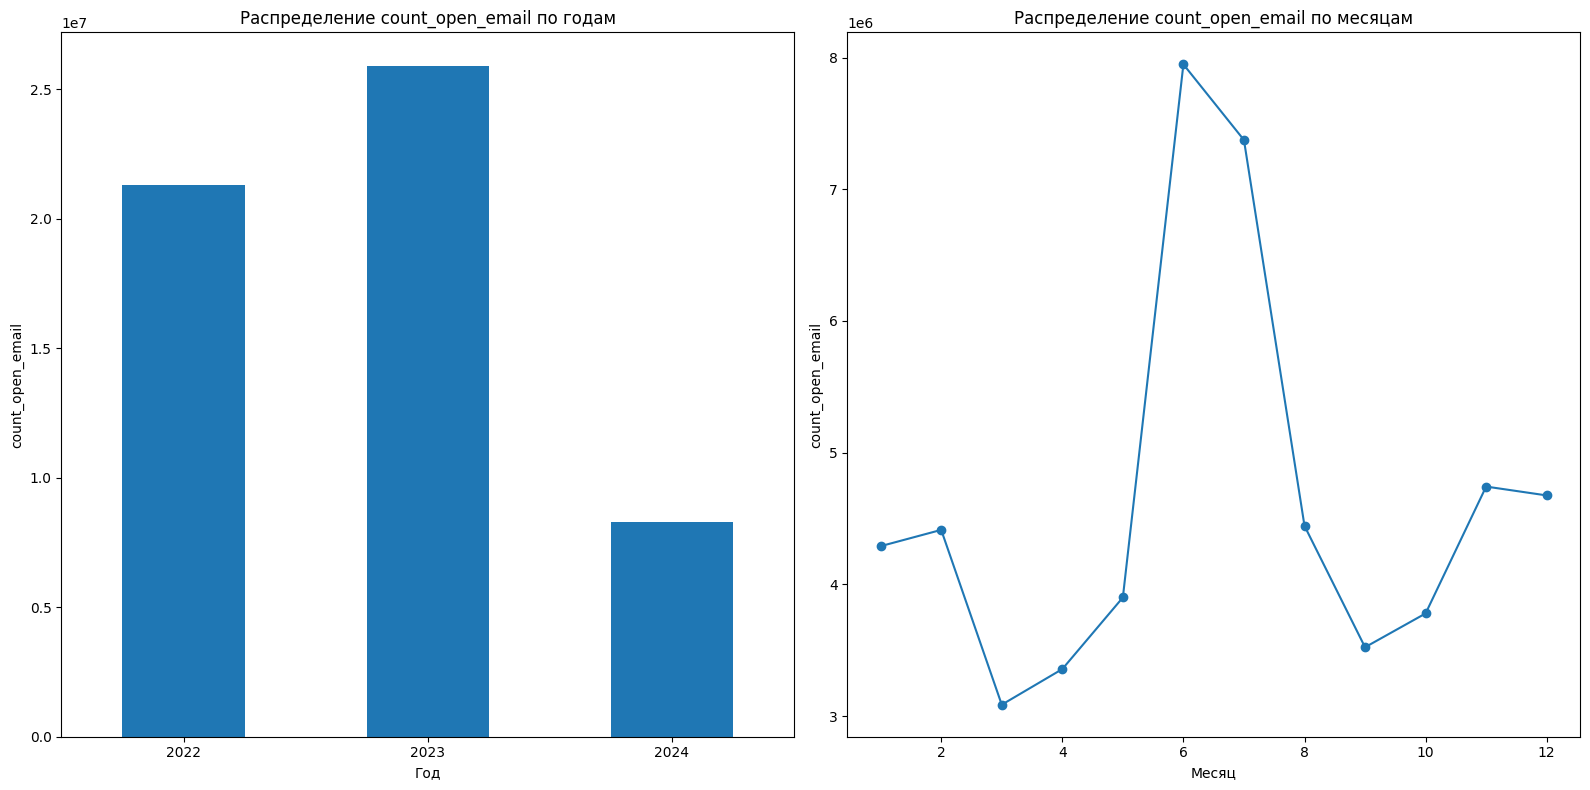

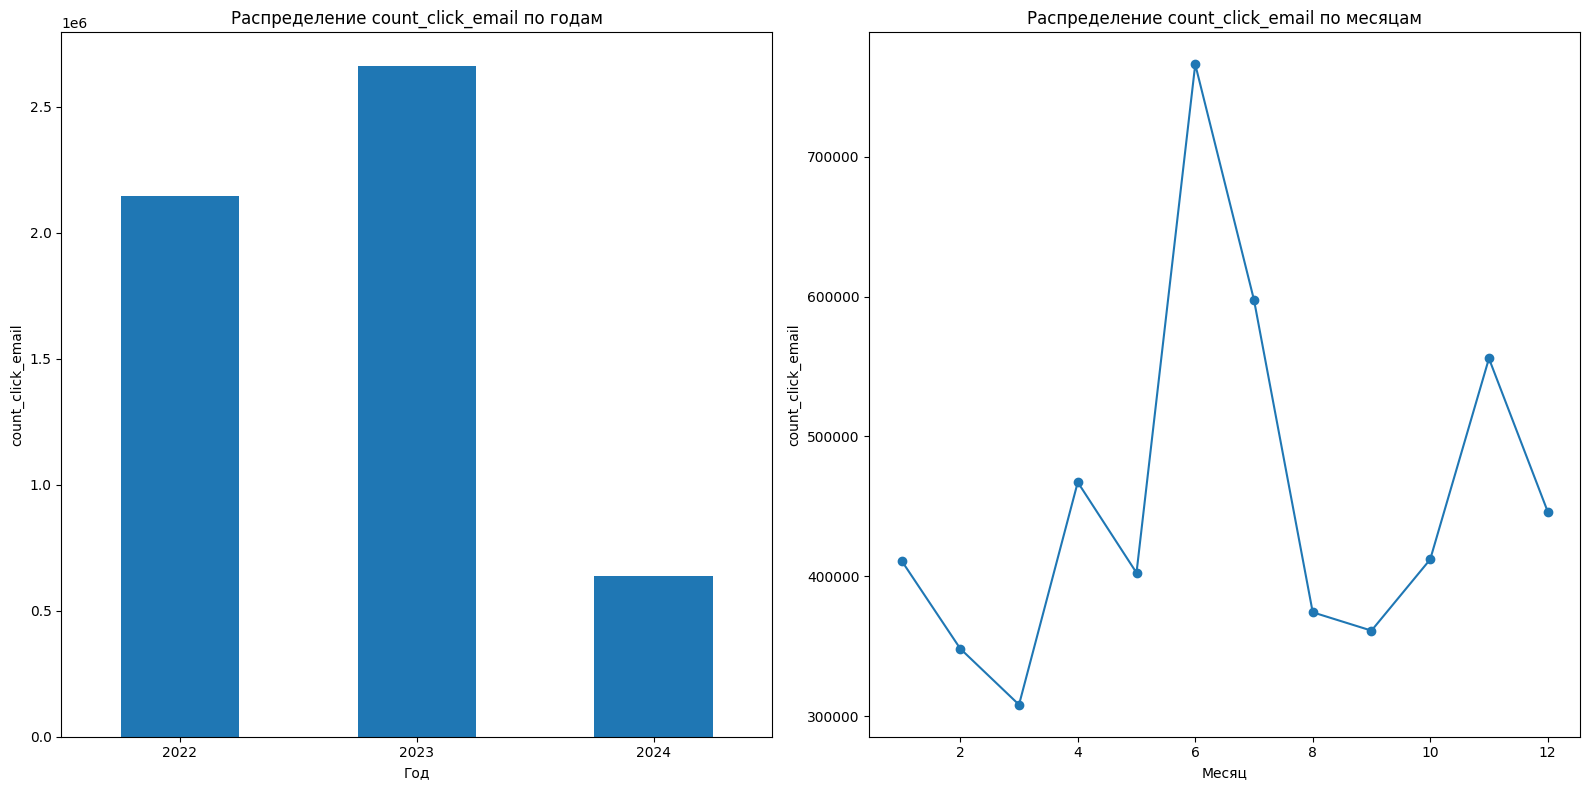

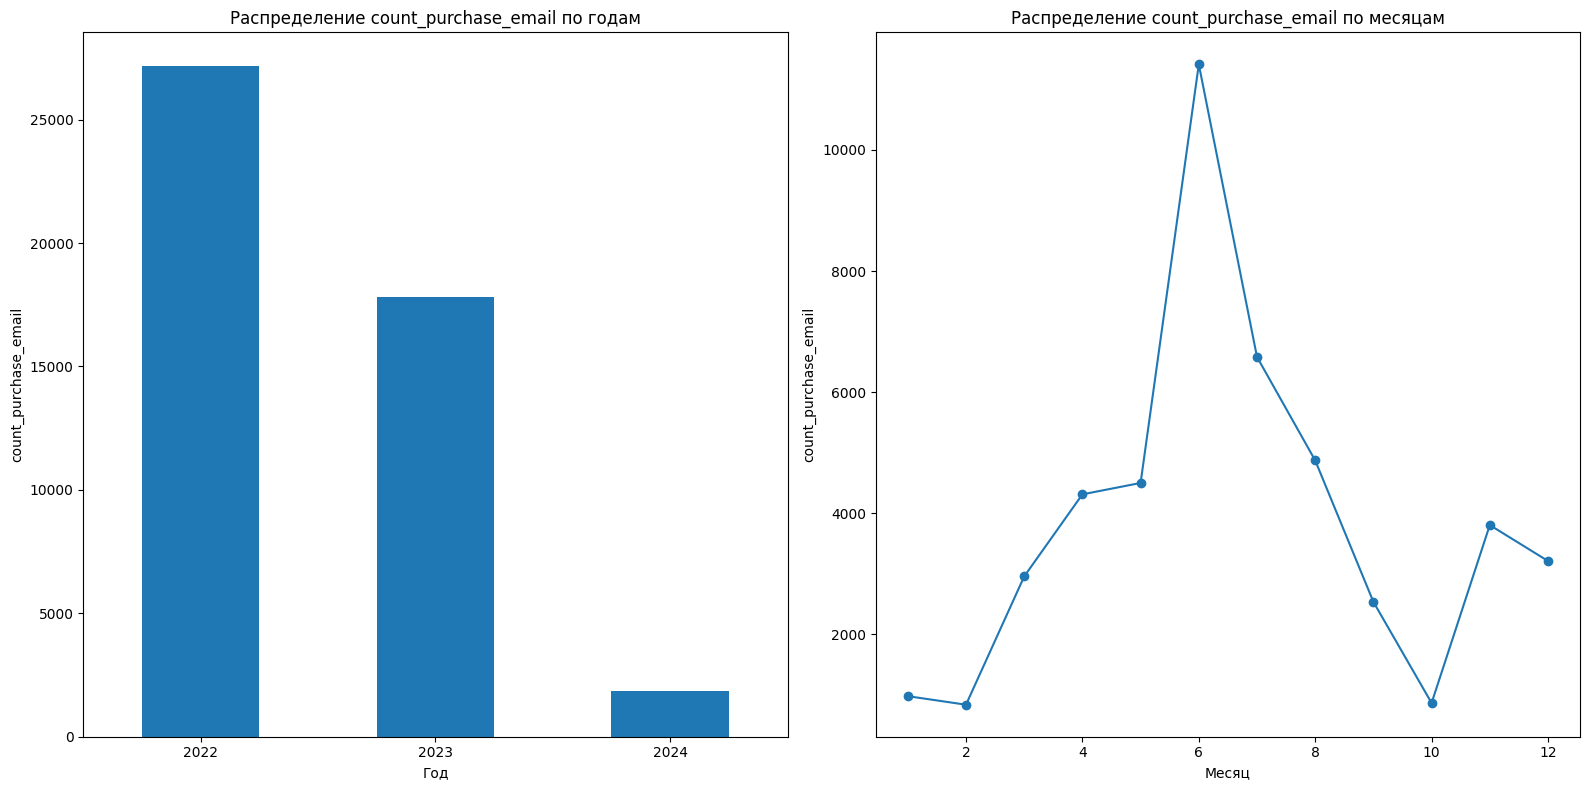

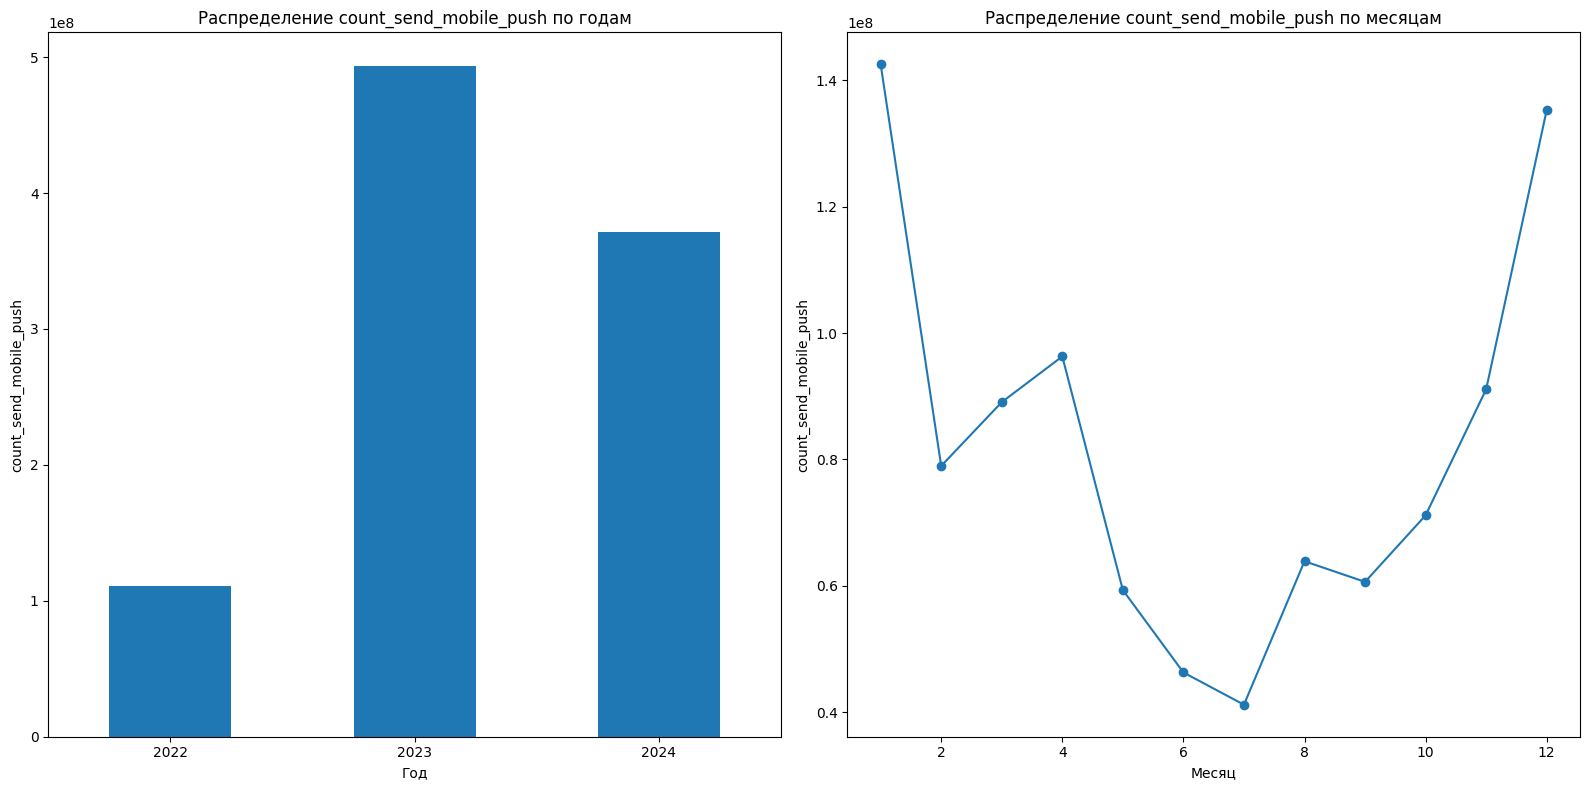

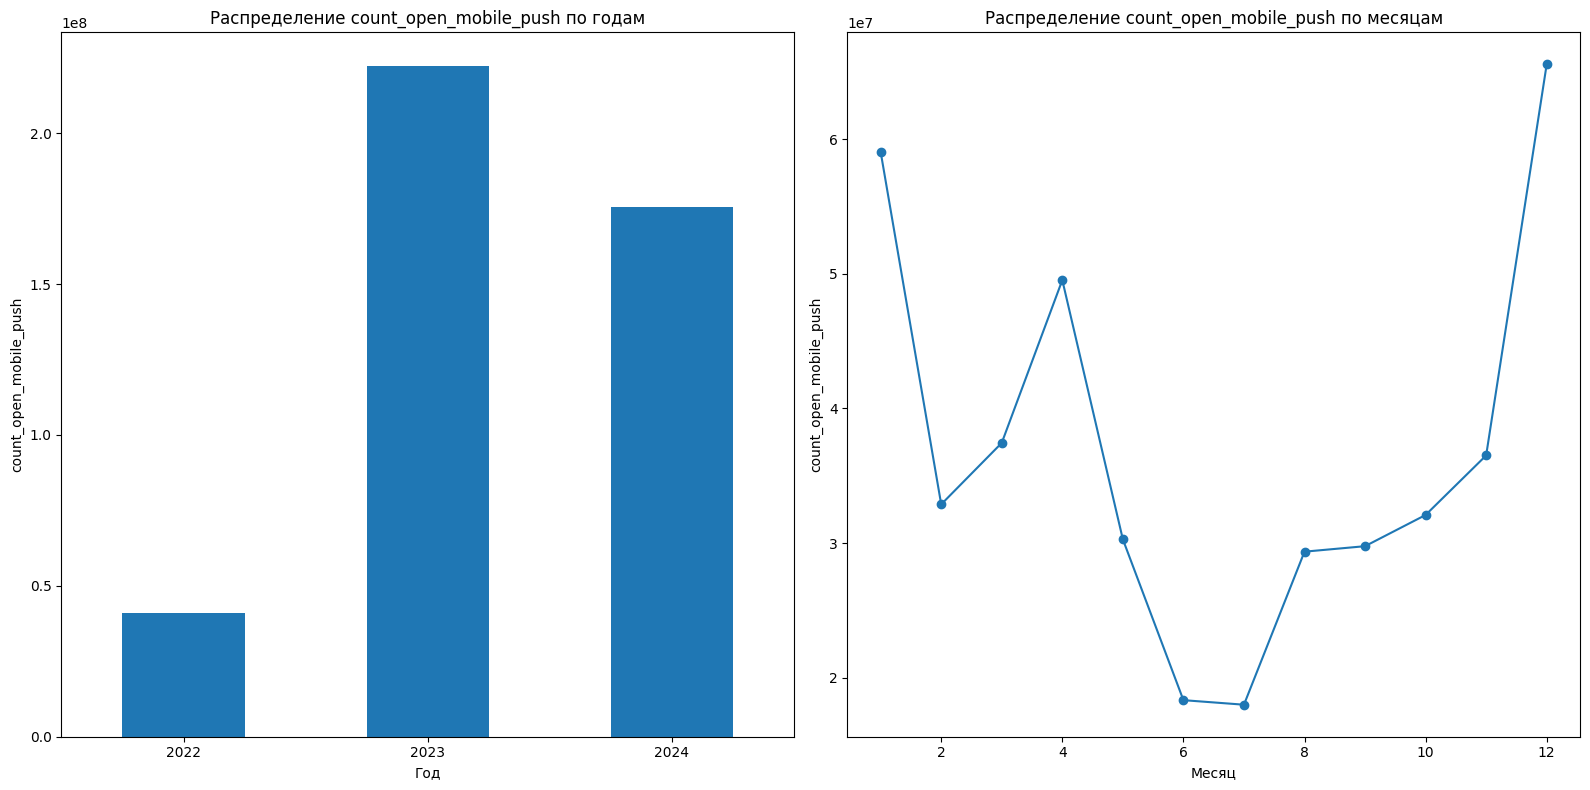

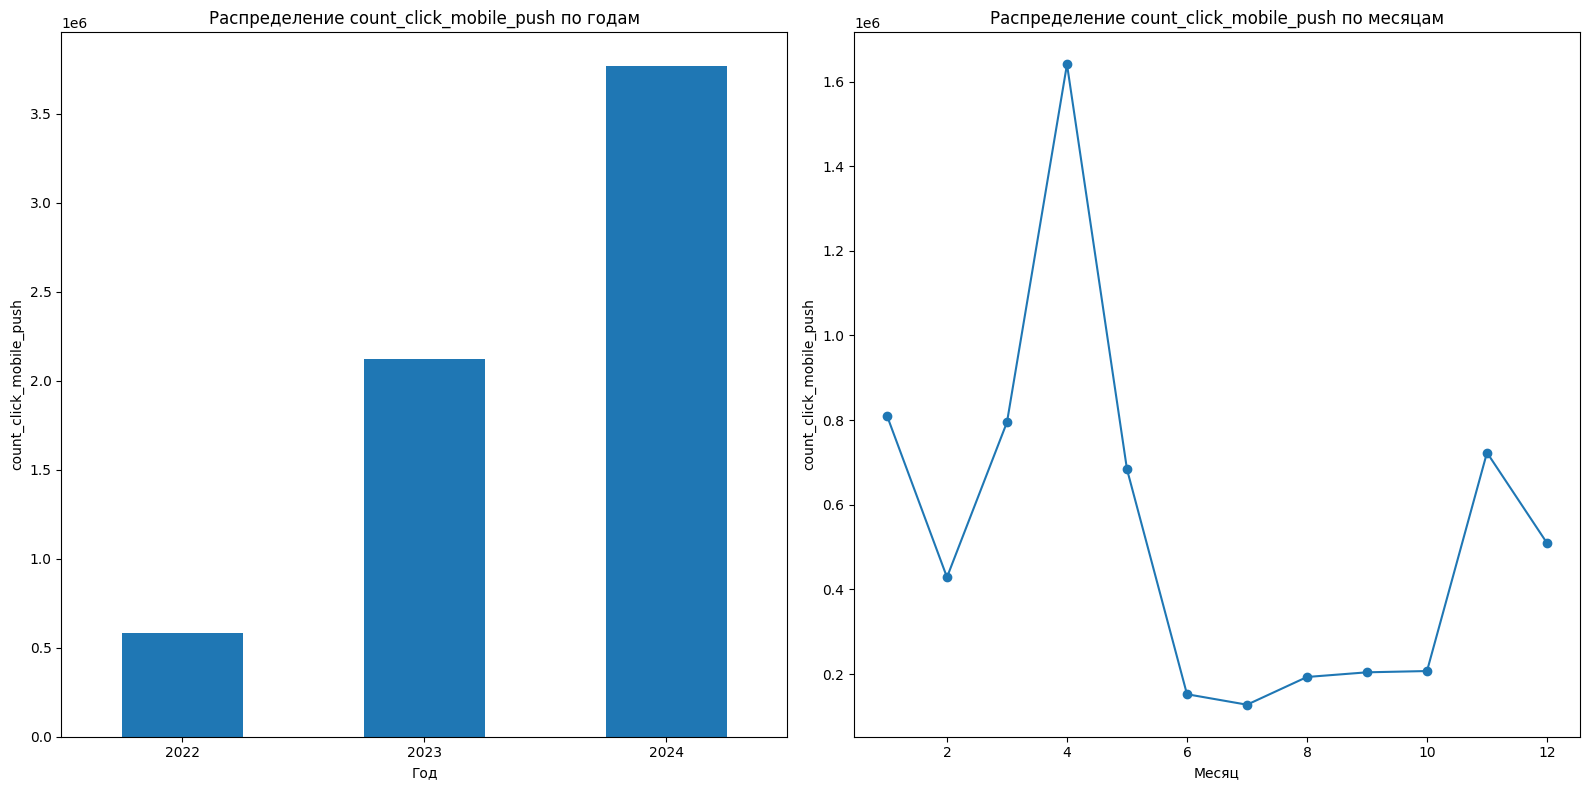

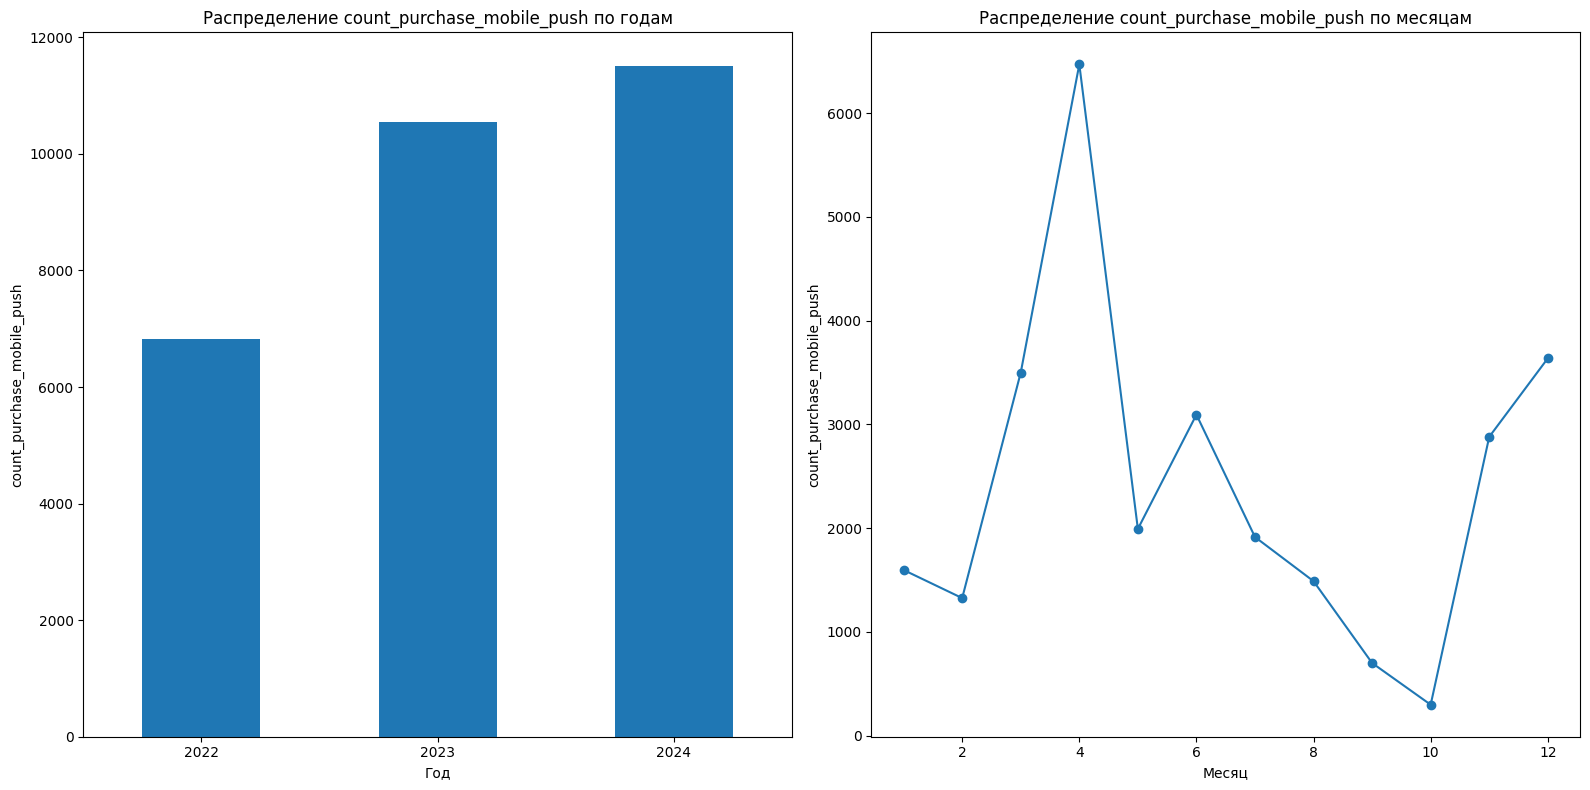

In [100]:
metrics = ['count_send_email', 'count_open_email', 'count_click_email', 'count_purchase_email',
           'count_send_mobile_push', 'count_open_mobile_push', 'count_click_mobile_push', 'count_purchase_mobile_push']

for metric in metrics:
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    df_grouped_year = campaign_daily_event_channel.groupby('year')[metric].sum()
    df_grouped_year.plot(kind='bar', ax=axs[0])
    
    for tick in axs[0].get_xticklabels():
        tick.set_rotation(0)
    
    
    axs[0].set_title(f'Распределение {metric} по годам')
    df_grouped_month = campaign_daily_event_channel.groupby('month')[metric].sum()
    df_grouped_month.plot(kind='line', marker='o', ax=axs[1])
     
    axs[1].set_title(f'Распределение {metric} по месяцам')
    
    axs[0].set_xlabel('Год')
    axs[1].set_xlabel('Месяц')
    axs[0].set_ylabel(f'{metric}')
    axs[1].set_ylabel(f'{metric}')
    
    plt.tight_layout()
    plt.show()
plt.close('all')

| Метрика | Лучшие месяцы | Худшие месяцы | Наблюдения |
|-|-|-|-|
| Отправка email | Июнь, Декабрь | Май, Сентябрь | Учебный процесс может влиять на активность (?) |
| Открытие email | Июнь, Июль | Март, Сентябрь | Квартальная отчетность на работе влияет на активность пользователей (?) |
| Клики в email | Июнь, Июль, Ноябрь | Февраль, Март, Сентябрь | Сезонность влияет на активность |
| Покупки в email | Июнь, Июль | Январь, Февраль, Октябрь | Количество покупок было самым высоким в 2022 году |
| Отправка push | Январь, Апрель, Ноябрь, Декабрь | Июнь, Июль | Летний спад активности (?) |
| Открытие push | Январь, Апрель, Декабрь | Июнь, Июль | Пользователи предпочитают отдых на природе? |
| Клики push | Январь, Март, Апрель | Летние месяцы, Октябрь | Рекордное количество кликов в 2024 году |
| Покупки в push | Март, Апрель, Июнь | Сентябрь, Октябрь | Ежегодный рост покупок наблюдается с 2022 по 2024 год |

**Коротко о campaign_daily_event_channel:**

1. Снова в датасете посмотрели лишь несколько колонок которые могут помочь нам в предсказании моделью факта покупи клиентом, а именно информацию по воронке продаж: отправка - открытие- клик- покупка, но в разрезе уже способа коммуникации: пуш или мейл
2. Нашли топ 10 успешных рекламных кампаний, которые сгенерировали больше всего в количественном плане покупок.
3. Топ 10 худших кампаний весь нулевой. Это навело на мысли глянуть сколько в принципе было кампаний, которые не спровоцировали ни одной покупки. Их ужасающе много: На мейле из 3181 кампании к покупке привели всего лишь 431. В пушах дело обстоит получше: там 1464 рекламных кампании привели к покупкам.
4. Изучение воронки в разрзе месяцев и годов описал под графиками в виде таблицы.
5. Как вариант можно будет использовать информацию вразрезе коммуникации: мейл или почта для создания новых синтетических признаков: соотношение отправленных мейлов и кол-во покупок, и такой же признак для пушей.

In [103]:
campaign_daily_event_channel['sale_funnel'] = np.where(
    campaign_daily_event_channel['count_send_email'] != 0,
    campaign_daily_event_channel['count_purchase_email'] / campaign_daily_event_channel['count_send_email'] * 100,
    np.nan
)

campaign_daily_event_channel['sale_funnel'] = np.where(
    campaign_daily_event_channel['count_send_mobile_push'] != 0,
    campaign_daily_event_channel['count_purchase_mobile_push'] / campaign_daily_event_channel['count_send_mobile_push'] * 100,
    np.nan
)

# Объединяем проценты для email и mobile_push
campaign_daily_event_channel['sale_funnel'] = (
    campaign_daily_event_channel['sale_funnel'].fillna(0) +
    campaign_daily_event_channel['sale_funnel'].fillna(0)
)

# Удаляем временные колонки
campaign_daily_event_channel.drop(['sale_funnel'], axis=1, inplace=True)


In [104]:
campaign_daily_event_channel['count_send_email'].value_counts()

count_send_email
0          130558
11520          34
18720           9
23040           7
11516           3
            ...  
74524           1
117715          1
1245            1
2609078         1
3585351         1
Name: count, Length: 464, dtype: int64

In [105]:
# Группируем и считаем сумму отправленных писем по кампаниям
email_sends_by_campaign = campaign_daily_event_channel.groupby('bulk_campaign_id')['count_send_email'].sum().rename('total_send_emails')
# Группируем и считаем сумму покупок через письма по кампаниям
purchases_by_email = campaign_daily_event_channel.groupby('bulk_campaign_id')['count_purchase_email'].sum().rename('total_purchases_email')
# Объединяем таблицы
result_df = email_sends_by_campaign.to_frame().join(purchases_by_email)
# Добавляем столбец с коэффициентом конверсии для email
result_df = result_df.assign(conversion_mail=lambda df: df['total_purchases_email'] / df['total_send_emails']).fillna(0)
# Объединение исходной таблицы с результатами
merged_df = campaign_daily_event_channel.merge(result_df, on='bulk_campaign_id', how='left')

# Группируем и считаем сумму отправленных пуш-уведомлений по кампаниям
push_sends_by_campaign = campaign_daily_event_channel.groupby('bulk_campaign_id')['count_send_mobile_push'].sum().rename('total_send_push')
# Группируем и считаем сумму покупок через пуш-уведомления по кампаниям
purchases_by_push = campaign_daily_event_channel.groupby('bulk_campaign_id')['count_purchase_mobile_push'].sum().rename('total_purchases_push')
# Объединяем таблицы
result_push_df = push_sends_by_campaign.to_frame().join(purchases_by_push)
# Добавляем столбец с коэффициентом конверсии для push
result_push_df = result_push_df.assign(conversion_push=lambda df: df['total_purchases_push'] / df['total_send_push']).fillna(0)
# Объединение исходной таблицы с результатами
merged_df = merged_df.merge(result_push_df, on='bulk_campaign_id', how='left')

In [106]:
merged_df['conversion_mail'].value_counts()

conversion_mail
0.000000    44946
inf         15255
0.000964      427
0.000488      404
0.000159      402
            ...  
0.001330       16
0.000013       14
0.000009       13
0.000016        9
0.000004        2
Name: count, Length: 379, dtype: int64

In [107]:
merged_df['conversion_mail'] = merged_df['conversion_mail'].replace(np.inf, 0)

In [108]:
merged_df['conversion_push'].value_counts()

conversion_push
0.000000    112708
0.005731        38
0.000082        35
0.000002        35
0.000010        34
             ...  
0.002822         1
0.001822         1
0.001065         1
0.000026         1
0.000047         1
Name: count, Length: 1421, dtype: int64

In [109]:
# Фильтрация и группировка для email-конверсий
non_zero_email_conversions = (
    merged_df.query("conversion_mail > 0")
      .groupby('bulk_campaign_id')
      .size()
      .reset_index(name='count')
)

print(f"Количество уникальных кампаний с ненулевой конверсией по email: {len(non_zero_email_conversions)}")

# Фильтрация и группировка для push-конверсий
non_zero_push_conversions = (
    merged_df.query("conversion_push > 0")
      .groupby('bulk_campaign_id')
      .size()
      .reset_index(name='count')
)

print(f"Количество уникальных кампаний с ненулевой конверсией по push: {len(non_zero_push_conversions)}")

Количество уникальных кампаний с ненулевой конверсией по email: 377
Количество уникальных кампаний с ненулевой конверсией по push: 1464


In [110]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 45 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   date                             131072 non-null  object 
 1   bulk_campaign_id                 131072 non-null  int64  
 2   count_click_email                131072 non-null  int64  
 3   count_click_mobile_push          131072 non-null  int64  
 4   count_open_email                 131072 non-null  int64  
 5   count_open_mobile_push           131072 non-null  int64  
 6   count_purchase_email             131072 non-null  int64  
 7   count_purchase_mobile_push       131072 non-null  int64  
 8   count_soft_bounce_email          131072 non-null  int64  
 9   count_subscribe_email            131072 non-null  int64  
 10  count_unsubscribe_email          131072 non-null  int64  
 11  nunique_click_email              131072 non-null  int64  
 12  nu

___

**Дальше соберем 1 датасет по которому уже будем проводить корелляционный анализ и обучать модель.**

In [113]:
unique_values_purchases = set(purchases['client_id'].unique())
unique_values_target_binary = set(target_binary['client_id'].unique())

# Сравниваем множества уникальных значений
if unique_values_purchases == unique_values_target_binary:
    print("Уникальные значения совпадают.")
else:
    print("Уникальные значения различаются!")

Уникальные значения различаются!


In [114]:
print(f'Количество уникальных client_id в purchases: {len(unique_values_purchases)}')
print(f'Количество уникальных client_id в target_binary: {len(unique_values_target_binary)}')

Количество уникальных client_id в purchases: 49827
Количество уникальных client_id в target_binary: 49849


In [115]:
missing_in_purchases = unique_values_target_binary - unique_values_purchases
missing_in_target_binary = unique_values_purchases - unique_values_target_binary

print(f'Клиенты, отсутствующие в purchases: {missing_in_purchases}')
print(f'Клиенты, отсутствующие в target_binary: {missing_in_target_binary}')

Клиенты, отсутствующие в purchases: {1515915625995466015, 1515915625977568800, 1515915625692218402, 1515915625489182504, 1515915625490563372, 1515915625487894579, 1515915625959777467, 1515915625995288129, 1515915625907962308, 1515915625472001227, 1515915625781028303, 1515915625576644304, 1515915625560295126, 1515915625491588310, 1515915625581952988, 1515915625726358492, 1515915626002366563, 1515915625971673322, 1515915625832206955, 1515915625906684917, 1515915625489090295, 1515915625981533561}
Клиенты, отсутствующие в target_binary: set()


In [116]:
data = purchases.merge(target_binary, on='client_id', how='inner')

In [117]:
# Определим нужные столбцы для объединения
selected_columns = ['event', 'channel']

# Создадим подмножество датафрейма messages с нужными столбцами
messages_subset = messages[['client_id', 'message_id'] + selected_columns]

# Выполним левое соединение
data_2 = data.merge(
    messages_subset,
    on=['client_id', 'message_id'],  # Объединение по client_id и message_id
    how='left'                       # Сохраняем все строки из data
)

In [118]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812725 entries, 0 to 812724
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   client_id      812725 non-null  int64         
 1   quantity       812725 non-null  int64         
 2   price          812725 non-null  float64       
 3   category_ids   812725 non-null  object        
 4   date           812725 non-null  datetime64[ns]
 5   message_id     812725 non-null  object        
 6   last_category  812725 non-null  int32         
 7   popularity     812725 non-null  object        
 8   month_year     812725 non-null  object        
 9   year           812725 non-null  int32         
 10  month          812725 non-null  int32         
 11  target         812725 non-null  int64         
 12  event          758592 non-null  object        
 13  channel        758592 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(3), int64(3)

In [119]:
#data_2.isna().sum()

In [120]:
#data_2.sample(n=2)

In [121]:
# del data_2['category_ids']

In [122]:
columns_to_check = ['client_id', 'message_id']
duplicates = data_2[data_2.duplicated(subset=columns_to_check)]
duplicates.head(1)

,client_id,quantity,price,category_ids,date,message_id,last_category,popularity,month_year,year,month,target,event,channel
1,1515915625468169594,1,2499.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,431,blockbuster,2022-05,2022,5,0,NaN,NaN


In [123]:
unique_indices = ~data_2.duplicated(subset=columns_to_check)
data_2 = data_2[unique_indices]

In [124]:
data_2['bulk_campaign_id'] = data_2['message_id'].str.split('-').str[1]
data_2.drop('message_id', axis=1, inplace=True)

In [125]:
data_2['bulk_campaign_id'] = data_2['bulk_campaign_id'].astype(int)

In [126]:
cols_to_merge = [
    'campaign_success',
    'total_send_emails',
    'total_purchases_email',
    'conversion_mail',
    'total_send_push',
    'total_purchases_push',
    'conversion_push'
]

# Выполняем слияние
df = data_2.merge(
    merged_df[['bulk_campaign_id'] + cols_to_merge],
    on='bulk_campaign_id',
    how='left'
)

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10827007 entries, 0 to 10827006
Data columns (total 21 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   client_id              int64         
 1   quantity               int64         
 2   price                  float64       
 3   category_ids           object        
 4   date                   datetime64[ns]
 5   last_category          int32         
 6   popularity             object        
 7   month_year             object        
 8   year                   int32         
 9   month                  int32         
 10  target                 int64         
 11  event                  object        
 12  channel                object        
 13  bulk_campaign_id       int32         
 14  campaign_success       object        
 15  total_send_emails      float64       
 16  total_purchases_email  float64       
 17  conversion_mail        float64       
 18  total_send_push     

In [128]:
columns_to_check = ['client_id', 'last_category', 'bulk_campaign_id']
duplicates = df[df.duplicated(subset=columns_to_check)]
duplicates

,client_id,quantity,price,category_ids,date,last_category,popularity,month_year,year,month,...,event,channel,bulk_campaign_id,campaign_success,total_send_emails,total_purchases_email,conversion_mail,total_send_push,total_purchases_push,conversion_push
1,1515915625468169594,1,1999.0,"[4, 28, 57, 431]",2022-05-16,431,blockbuster,2022-05,2022,5,...,NaN,NaN,4301,neutral,0.0,21.0,0.000000,0.0,0.0,0.0
2,1515915625468169594,1,1999.0,"[4, 28, 57, 431]",2022-05-16,431,blockbuster,2022-05,2022,5,...,NaN,NaN,4301,unsuccessful,0.0,21.0,0.000000,0.0,0.0,0.0
3,1515915625468169594,1,1999.0,"[4, 28, 57, 431]",2022-05-16,431,blockbuster,2022-05,2022,5,...,NaN,NaN,4301,neutral,0.0,21.0,0.000000,0.0,0.0,0.0
4,1515915625468169594,1,1999.0,"[4, 28, 57, 431]",2022-05-16,431,blockbuster,2022-05,2022,5,...,NaN,NaN,4301,neutral,0.0,21.0,0.000000,0.0,0.0,0.0
5,1515915625468169594,1,1999.0,"[4, 28, 57, 431]",2022-05-16,431,blockbuster,2022-05,2022,5,...,NaN,NaN,4301,unsuccessful,0.0,21.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10827002,1515915626010443624,1,999.0,"[4, 28, 62, 656]",2024-02-16,656,top,2024-02,2024,2,...,NaN,NaN,14668,unsuccessful,1811866.0,39.0,0.000022,0.0,0.0,0.0
10827003,1515915626010443624,1,999.0,"[4, 28, 62, 656]",2024-02-16,656,top,2024-02,2024,2,...,NaN,NaN,14668,unsuccessful,1811866.0,39.0,0.000022,0.0,0.0,0.0
10827004,1515915626010443624,1,999.0,"[4, 28, 62, 656]",2024-02-16,656,top,2024-02,2024,2,...,NaN,NaN,14668,unsuccessful,1811866.0,39.0,0.000022,0.0,0.0,0.0
10827005,1515915626010443624,1,999.0,"[4, 28, 62, 656]",2024-02-16,656,top,2024-02,2024,2,...,NaN,NaN,14668,unsuccessful,1811866.0,39.0,0.000022,0.0,0.0,0.0


In [129]:
unique_indices = ~df.duplicated(subset=columns_to_check)
df = df[unique_indices]

In [130]:
del df['category_ids']

In [131]:
explore_dataset(df)

Info:
<class 'pandas.core.frame.DataFrame'>
Index: 58301 entries, 0 to 10826917
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   client_id              58301 non-null  int64         
 1   quantity               58301 non-null  int64         
 2   price                  58301 non-null  float64       
 3   date                   58301 non-null  datetime64[ns]
 4   last_category          58301 non-null  int32         
 5   popularity             58301 non-null  object        
 6   month_year             58301 non-null  object        
 7   year                   58301 non-null  int32         
 8   month                  58301 non-null  int32         
 9   target                 58301 non-null  int64         
 10  event                  44038 non-null  object        
 11  channel                44038 non-null  object        
 12  bulk_campaign_id       58301 non-null  int32         
 1

,client_id,quantity,price,date,last_category,year,month,target,bulk_campaign_id,total_send_emails,total_purchases_email,conversion_mail,total_send_push,total_purchases_push,conversion_push
count,5.830100e+04,58301.000000,58301.000000,58301,58301.000000,58301.000000,58301.000000,58301.000000,58301.000000,5.828800e+04,58288.000000,58288.000000,5.828800e+04,58288.000000,5.828800e+04
mean,1.515916e+18,1.010823,1487.907017,2023-02-04 12:42:04.526166016,780.366031,2022.550831,7.081131,0.026998,9616.059484,1.651073e+06,404.231231,0.000250,5.779420e+05,37.225878,inf
min,1.515916e+18,1.000000,1.000000,2022-05-16 00:00:00,413.000000,2022.000000,1.000000,0.000000,563.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
25%,1.515916e+18,1.000000,629.000000,2022-08-08 00:00:00,432.000000,2022.000000,5.000000,0.000000,5792.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
50%,1.515916e+18,1.000000,1287.000000,2023-01-13 00:00:00,510.000000,2023.000000,7.000000,0.000000,9197.000000,1.243139e+06,177.000000,0.000102,0.000000e+00,0.000000,0.000000e+00
75%,1.515916e+18,1.000000,1999.000000,2023-06-17 00:00:00,673.000000,2023.000000,9.000000,0.000000,13358.000000,2.825593e+06,566.000000,0.000319,3.225320e+05,13.000000,1.538689e-05
max,1.515916e+18,30.000000,19999.000000,2024-02-16 00:00:00,6323.000000,2024.000000,12.000000,1.000000,14669.000000,7.094600e+06,2494.000000,0.003880,2.110216e+07,519.000000,inf
std,1.444152e+08,0.237055,1279.778743,NaN,822.262363,0.579682,3.070018,0.162078,3605.837784,1.753416e+06,550.512666,0.000484,1.376792e+06,91.283954,NaN



Sample (n=2):


,client_id,quantity,price,date,last_category,popularity,month_year,year,month,target,event,channel,bulk_campaign_id,campaign_success,total_send_emails,total_purchases_email,conversion_mail,total_send_push,total_purchases_push,conversion_push
3432987,1515915625500270780,1,999.0,2022-07-02,857,popular,2022-07,2022,7,0,send,mobile_push,5254,unsuccessful,0.0,0.0,0.0,994442.0,355.0,0.000357
10666374,1515915625538563695,1,349.0,2023-12-22,1173,trendy,2023-12,2023,12,0,send,mobile_push,14351,unsuccessful,0.0,0.0,0.0,249939.0,49.0,0.000196



Количество пропусков в каждой колонке:


client_id                    0
quantity                     0
price                        0
date                         0
last_category                0
popularity                   0
month_year                   0
year                         0
month                        0
target                       0
event                    14263
channel                  14263
bulk_campaign_id             0
campaign_success            13
total_send_emails           13
total_purchases_email       13
conversion_mail             13
total_send_push             13
total_purchases_push        13
conversion_push             13
dtype: int64


Количество уникальных значений в каждой колонке:


client_id                49827
quantity                    13
price                     2566
date                       642
last_category              767
popularity                  10
month_year                  22
year                         3
month                       12
target                       2
event                        5
channel                      2
bulk_campaign_id          1552
campaign_success             3
total_send_emails          343
total_purchases_email      168
conversion_mail            343
total_send_push           1093
total_purchases_push       121
conversion_push           1111
dtype: int64

Сделал итоговый датасет, в который добавил все признаки которые планировали релаизовать. Если честно нстолько потно было объединять датасеты что ужас. Очень сильно надеюсь, что объединение везде по итогу прошло верно, но выглядит очень костыльно. Я на это еще и убил 4 полных вечера по 4 часа ... сейчас немного причешем, делаем корреляционный анализ и идем запускать его в модель.  

In [133]:
df[['event', 'channel']] = df[['event', 'channel']].fillna("other")
df = df.dropna()
df = df.set_index('client_id')
df.rename(columns={'date': 'day'}, inplace=True)
df['day'] = df['day'].dt.day

In [134]:
infinite_values = df.isin([np.inf, -np.inf])

# Выводим строки, содержащие хотя бы одно бесконечное значение
df[infinite_values.any(axis=1)]


,quantity,price,day,last_category,popularity,month_year,year,month,target,event,channel,bulk_campaign_id,campaign_success,total_send_emails,total_purchases_email,conversion_mail,total_send_push,total_purchases_push,conversion_push
client_id,,,,,,,,,,,,,,,,,,,
1515915625471138230,1,6499.0,16,431,blockbuster,2022-05,2022,5,0,other,other,4437,unsuccessful,0.0,0.0,0.0,0.0,1.0,inf
1515915625491651493,1,699.0,16,678,hit,2022-05,2022,5,0,other,other,4437,unsuccessful,0.0,0.0,0.0,0.0,1.0,inf
1515915625635645824,1,2399.0,17,421,top,2022-05,2022,5,0,other,other,4437,unsuccessful,0.0,0.0,0.0,0.0,1.0,inf
1515915625677462345,1,2199.0,17,420,blockbuster,2022-05,2022,5,0,other,other,4437,unsuccessful,0.0,0.0,0.0,0.0,1.0,inf
1515915625544083417,1,2499.0,18,1052,frequent,2022-05,2022,5,0,purchase,mobile_push,4478,unsuccessful,0.0,0.0,0.0,0.0,1.0,inf
1515915625566603244,1,799.0,18,505,top,2022-05,2022,5,0,other,other,4478,unsuccessful,0.0,0.0,0.0,0.0,1.0,inf
1515915625481861208,1,139.0,19,1778,moderate,2022-05,2022,5,0,purchase,mobile_push,4479,unsuccessful,0.0,0.0,0.0,0.0,1.0,inf
1515915625489777178,1,2199.0,22,431,blockbuster,2022-05,2022,5,0,click,mobile_push,4437,unsuccessful,0.0,0.0,0.0,0.0,1.0,inf


In [135]:
indexes_to_remove = infinite_values.any(axis=1)
df = df[~indexes_to_remove]

In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58280 entries, 1515915625468169594 to 1515915626010443624
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   quantity               58280 non-null  int64  
 1   price                  58280 non-null  float64
 2   day                    58280 non-null  int32  
 3   last_category          58280 non-null  int32  
 4   popularity             58280 non-null  object 
 5   month_year             58280 non-null  object 
 6   year                   58280 non-null  int32  
 7   month                  58280 non-null  int32  
 8   target                 58280 non-null  int64  
 9   event                  58280 non-null  object 
 10  channel                58280 non-null  object 
 11  bulk_campaign_id       58280 non-null  int32  
 12  campaign_success       58280 non-null  object 
 13  total_send_emails      58280 non-null  float64
 14  total_purchases_email  5828

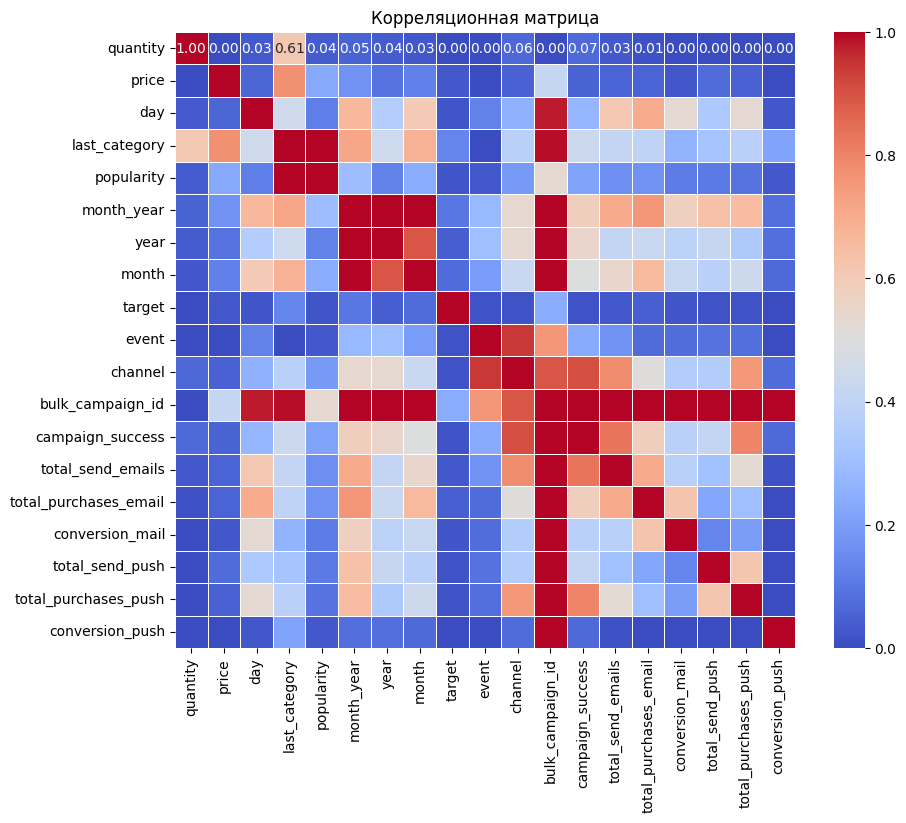

In [137]:
interval_cols=[
            'price', 'total_send_emails',
            'total_purchases_email', 'conversion_mail',
            'total_send_push', 'total_purchases_push','conversion_push'
        ]

phik_matrix = df.phik_matrix(interval_cols=interval_cols)
plt.figure(figsize=(10, 8))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Корреляционная матрица")
plt.show()

In [138]:
phik_matrix.applymap(lambda x: round(x, 3))

,quantity,price,day,last_category,popularity,month_year,year,month,target,event,channel,bulk_campaign_id,campaign_success,total_send_emails,total_purchases_email,conversion_mail,total_send_push,total_purchases_push,conversion_push
quantity,1.000,0.000,0.032,0.611,0.039,0.053,0.038,0.025,0.000,0.000,0.064,0.000,0.069,0.031,0.014,0.003,0.001,0.000,0.000
price,0.000,1.000,0.061,0.770,0.233,0.165,0.093,0.121,0.030,0.000,0.048,0.416,0.055,0.055,0.055,0.024,0.071,0.047,0.000
day,0.032,0.061,1.000,0.445,0.120,0.667,0.366,0.605,0.022,0.128,0.255,0.978,0.276,0.617,0.702,0.529,0.343,0.530,0.024
last_category,0.611,0.770,0.445,1.000,1.000,0.715,0.443,0.686,0.137,0.000,0.377,0.989,0.437,0.411,0.395,0.262,0.322,0.380,0.219
popularity,0.039,0.233,0.120,1.000,1.000,0.294,0.126,0.239,0.023,0.030,0.190,0.533,0.215,0.158,0.165,0.112,0.107,0.092,0.029
month_year,0.053,0.165,0.667,0.715,0.294,1.000,1.000,1.000,0.101,0.285,0.539,1.000,0.583,0.703,0.755,0.580,0.635,0.655,0.081
year,0.038,0.093,0.366,0.443,0.126,1.000,1.000,0.893,0.041,0.301,0.534,1.000,0.547,0.413,0.427,0.390,0.418,0.347,0.080
month,0.025,0.121,0.605,0.686,0.239,1.000,0.893,1.000,0.074,0.194,0.428,0.999,0.500,0.547,0.659,0.422,0.380,0.438,0.068
target,0.000,0.030,0.022,0.137,0.023,0.101,0.041,0.074,1.000,0.019,0.018,0.240,0.019,0.030,0.046,0.022,0.018,0.017,0.000
event,0.000,0.000,0.128,0.000,0.030,0.285,0.301,0.194,0.019,1.000,0.942,0.755,0.236,0.164,0.072,0.076,0.089,0.081,0.000


Почему-то у меня цифрами данные не отобразились на хитмепе, но  ладнооо. с таргетом корреляция невероятно слабая:  категория покупки 13.7%; ммесяц покупки 10%. остальное и того меньше. Что же, посмотрим...

___

## Фичинженеринг

Он у меня плавно в EDA прошел

## Выбор лучшей модели

Соберем пайплайном сразу несколько моделей. 

In [145]:
#Разделение данных на признаки и целевую переменную
X = df.drop('target', axis=1)
y = df['target']

#Разделение данных на тренировочные и тестовые наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#Определение категориальных и количественных признаков
cat_columns = ['last_category', 'popularity', 'month_year', 'day', 'year', 
                        'month', 'event', 'channel', 'bulk_campaign_id', 'campaign_success']
num_columns = ['quantity', 'price', 'total_send_emails', 'total_purchases_email', 'conversion_mail', 
               'total_send_push', 'total_purchases_push', 'conversion_push']

In [146]:
#Создание трансформера для категориальных признаков
categorical_transformer = Pipeline(steps=[
    ('te', TargetEncoder(cols=cat_columns))
])

#Создание трансформера для количественных признаков
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

#Комбинация трансформеров
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, cat_columns),
        ('num', numeric_transformer, num_columns)
    ]
)


In [147]:
#Определение гиперпараметров для моделей
lgbm_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'random_state': 42
}

catb_params = {
    'iterations': 1000,
    'depth': 10,
    'learning_rate': 0.03,
    'loss_function': 'RMSE',
    'eval_metric': 'AUC',
    'od_type': 'Iter',
    'od_wait': 20,
    'random_seed': 42
}

rf_params = {
    'n_estimators': 200,
    'max_depth': 25,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'random_state': 42
}

In [148]:
#Создание и обучение моделей
models = {
    'LightGBM': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LGBMRegressor(**lgbm_params))
    ]),
    'Linear Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ]),
    'CatBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', CatBoostRegressor(**catb_params))
    ]),
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(**rf_params))
    ])
}

#cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [149]:
best_model = None
best_score = float('-inf')

for model_name, pipeline in models.items():
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc')
    mean_score = np.mean(scores)
    
    if mean_score > best_score:
        best_model = model_name
        best_score = mean_score
        


# Теперь рассчитаем ROC AUC для лучшей модели на тестовых данных
pipeline = models[best_model]
pipeline.fit(X_train, y_train)
#y_pred = pipeline.predict(X_test)[:, 1]
#auc = roc_auc_score(y_test, y_pred)

if best_model == 'Random Forest':
    y_pred = pipeline.predict(X_test)
else:
    y_pred = pipeline.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 

In [150]:
print(f'Лучшая модель: {best_model}, средний ROC AUC: {best_score:.4f}')
print(f'ROC AUC для лучшей модели ({best_model}) на тестовых данных: {auc:.4f}')

Лучшая модель: Random Forest, средний ROC AUC: 0.6146
ROC AUC для лучшей модели (Random Forest) на тестовых данных: 0.6231


**Метрика не достигла показателя который был задан бизнесом. Подготовим данные иначе и попробуем заново.**

In [152]:
messages = pd.read_csv(r'D:\Study\project\practikum_project\masterka_2\filtered_data\apparel-messages.csv')
purchases = pd.read_csv(r"D:\Study\project\practikum_project\masterka_2\filtered_data\apparel-purchases.csv")
target_binary = pd.read_csv(r"D:\Study\project\practikum_project\masterka_2\filtered_data\apparel-target_binary.csv")

In [153]:
messages['date'] = pd.to_datetime(messages['date'])

messages['day_of_week'] = messages['date'].dt.dayofweek
messages['month'] = messages['date'].dt.month
messages['year'] = messages['date'].dt.year

In [154]:
messages['client_events_count'] = messages.groupby('client_id')['event'].transform('count')
messages['campaigns_per_client'] = messages.groupby(['bulk_campaign_id', 'client_id'])['event'].transform('size')

In [155]:
interesting_events = ['send', 'open', 'click', 'purchase']
filtered_df = messages.query("event in @interesting_events")

grouped = filtered_df.groupby(['client_id', 'event'])

events_count = grouped.size().unstack(fill_value=0)
messages = messages.merge(events_count, on='client_id', how='left')

# Переименовываем колонки для удобства
messages.rename(columns={'send': 'sent_messages',
                   'open': 'opened_messages',
                   'click': 'clicked_messages',
                   'purchase': 'purchases'}, inplace=True)

messages['conversion_sent_to_opened'] = ((messages['opened_messages'] / messages['sent_messages']).replace(np.inf, 0)).round(4)
messages['conversion_opened_to_clicked'] = ((messages['clicked_messages'] / messages['opened_messages']).replace(np.inf, 0)).round(4)
messages['conversion_clicked_to_purchased'] = ((messages['purchases'] / messages['clicked_messages']).replace(np.inf, 0)).round(4)

In [156]:
# заполняем пропуски 0. значения NaN появились из-за деления на 0, хотя в коде выше я вроде бы это пытался заранее учесть...
messages['conversion_sent_to_opened'].fillna(0, inplace=True)
messages['conversion_opened_to_clicked'].fillna(0, inplace=True)
messages['conversion_clicked_to_purchased'].fillna(0, inplace=True)

In [157]:
# Определяем список колонок для группировки и агрегации
aggregation_dict = {
    'bulk_campaign_id': 'nunique',  # Количество уникальных кампаний
    'message_id': 'nunique',        # Количество уникальных сообщений
    'client_events_count': 'max',   # Максимальное количество событий для клиента
    'campaigns_per_client': 'max',  # Максимальное количество кампаний для клиента
    'clicked_messages': 'max',      # Максимальное количество кликов
    'opened_messages': 'max',       # Максимальное количество открытий
    'purchases': 'max',             # Максимальная покупка
    'sent_messages': 'max',         # Максимальное количество отправленных сообщений
    'conversion_sent_to_opened': 'mean',  # Среднее значение конверсии отправлено-открыто
    'conversion_opened_to_clicked': 'mean',  # Среднее значение конверсии открыто-кликнуто
    'conversion_clicked_to_purchased': 'mean'  # Среднее значение конверсии кликнуто-покупка
}

# Группировка по client_id и агрегирование по указанным функциям
sint_mes = messages.groupby('client_id').agg(aggregation_dict)

renamed_columns = {
    'bulk_campaign_id': 'count_campaigns',
    'message_id': 'count_messages',
}

# Применяем переименование
sint_mes.rename(columns=renamed_columns, inplace=True)

sint_mes.reset_index(inplace=True)

**Кратко об изменениях:**
1. Фильтрация данных: Отобраны только нужные события ("send", "open", "click", "purchase") для анализа воронки продаж.
2. Подсчёт количества событий: Посчитано количество отправленных, открытых, кликнутых сообщений и совершенных покупок для каждого клиента.
3. Расчёт конверсий: Рассчитаны три ключевых показателя конверсии:
   - Отправленные → Открытые
   - Открытые → Кликнутые
   - Кликнутые → Покупки

Итого: Получен новый датафрейм с количеством событий и показателями конверсии для каждого клиента, что позволит улучшить (я надеюсь) показатели моделей. 

- client_id — Идентификатор клиента
- count_campaigns — Количество кампаний
- count_messages — Количество сообщений
- client_events_count — Общее количество событий для клиента
- campaigns_per_client — Количество кампаний для конкретного клиента
- clicked_messages — Клики по сообщениям
- opened_messages — Открытия сообщений
- purchases — Покупки
- sent_messages — Отправленные сообщения
- conversion_sent_to_opened — Конверсия отправленных в открытые
- conversion_opened_to_clicked — Конверсия открытых в клики
- conversion_clicked_to_purchased — Конверсия кликов в покупки

___

In [160]:
purchases['date'] = pd.to_datetime(purchases['date'])

In [161]:
purchases['category_ids'] = purchases['category_ids'].apply(ast.literal_eval)
purchases['entry'] = purchases['category_ids'].str[0]
purchases['cat_2'] = purchases['category_ids'].str[1]
purchases['cat_3'] = purchases['category_ids'].str[2]
purchases['purchase_cat'] = purchases['category_ids'].str[3]

In [162]:
df_avg_price = purchases.groupby('client_id')['price'].mean().reset_index(name='average_purchase_price')
df_max_price = purchases.groupby('client_id')['price'].max().reset_index(name='max_purchase_price')
df_min_price = purchases.groupby('client_id')['price'].min().reset_index(name='min_purchase_price')
df_total_spent = purchases.groupby('client_id')['price'].sum().reset_index(name='total_spent')

popular_categories = purchases.groupby(['client_id', 'purchase_cat']).size().to_frame('count').reset_index()
popular_categories = popular_categories.sort_values(['client_id', 'count'], ascending=[True, False]).groupby('client_id').head(1).reset_index(drop=True)

sorted_df = purchases.sort_values(by=['client_id', 'date'])
first_purchases = sorted_df.drop_duplicates(subset='client_id', keep='first')[['client_id', 'date']]
first_purchases.rename(columns={'date': 'first_purchase'}, inplace=True)
last_purchases = sorted_df.drop_duplicates(subset='client_id', keep='last')[['client_id', 'date']]
last_purchases.rename(columns={'date': 'last_purchase'}, inplace=True)

In [163]:
# Объединение всех данных
data = df_avg_price \
           .merge(df_max_price, on='client_id', how='left') \
           .merge(df_min_price, on='client_id', how='left') \
           .merge(df_total_spent, on='client_id', how='left') \
           .merge(popular_categories[['client_id', 'purchase_cat']], on='client_id', how='left') \
           .merge(first_purchases, on='client_id', how='left') \
           .merge(last_purchases, on='client_id', how='left')

**Подведем итоги проделанной работы:**

Средняя цена покупки: Мы нашли среднюю стоимость одной покупки для каждого клиента.
Максимальная и минимальная цена покупки: Определили самые дорогие и дешевые товары, которые покупали клиенты.
Общий объем потраченных средств: Посчитали, сколько денег каждый клиент потратил за весь период наблюдений.
Наиболее популярные категории: Найденные категории показывают, какие товары чаще всего покупались клиентами.
Первые и последние покупки: Установлены даты первых и последних покупок для каждого клиента.
Все эти синтетические признаки были созданы на основе исходных данных

In [165]:
df = target_binary.merge(sint_mes, on='client_id', how='left') \
                  .merge(data, on='client_id', how='left')

In [166]:
explore_dataset(df)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   client_id                        49849 non-null  int64         
 1   target                           49849 non-null  int64         
 2   count_campaigns                  41982 non-null  float64       
 3   count_messages                   41982 non-null  float64       
 4   client_events_count              41982 non-null  float64       
 5   campaigns_per_client             41982 non-null  float64       
 6   clicked_messages                 41982 non-null  float64       
 7   opened_messages                  41982 non-null  float64       
 8   purchases                        41982 non-null  float64       
 9   sent_messages                    41982 non-null  float64       
 10  conversion_sent_to_opened        41982 non-null  flo

,client_id,target,count_campaigns,count_messages,client_events_count,campaigns_per_client,clicked_messages,opened_messages,purchases,sent_messages,conversion_sent_to_opened,conversion_opened_to_clicked,conversion_clicked_to_purchased,average_purchase_price,max_purchase_price,min_purchase_price,total_spent,first_purchase,last_purchase
count,4.984900e+04,49849.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849,49849
mean,1.515916e+18,0.019278,186.284289,188.226478,260.848006,6.182769,10.852318,59.772450,1.371731,188.152470,0.317119,0.471395,0.287839,1483.415229,1792.131377,1238.219884,4840.520632,2023-01-28 22:28:08.314710272,2023-02-19 01:38:30.329193984
min,1.515916e+18,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,2022-05-16 00:00:00,2022-05-16 00:00:00
25%,1.515916e+18,0.000000,114.000000,115.000000,147.000000,4.000000,3.000000,4.000000,1.000000,115.000000,0.030825,0.014200,0.066700,699.000000,910.000000,399.000000,1499.000000,2022-08-03 00:00:00,2022-08-23 00:00:00
50%,1.515916e+18,0.000000,174.000000,175.000000,233.000000,5.000000,6.000000,26.000000,1.000000,175.000000,0.202300,0.125900,0.150000,1249.000000,1499.000000,999.000000,2929.000000,2022-12-26 00:00:00,2023-03-05 00:00:00
75%,1.515916e+18,0.000000,257.000000,260.000000,351.000000,7.000000,14.000000,94.000000,2.000000,260.000000,0.525875,0.500000,0.333300,1999.000000,2199.000000,1749.000000,5677.000000,2023-06-14 00:00:00,2023-06-28 00:00:00
max,1.515916e+18,1.000000,2465.000000,2473.000000,3100.000000,438.000000,384.000000,1268.000000,103.000000,2473.000000,9.000000,84.000000,25.333300,53499.000000,85499.000000,53499.000000,540408.000000,2024-02-16 00:00:00,2024-02-16 00:00:00
std,1.487947e+08,0.137503,103.524484,104.672625,160.084120,5.033885,14.164661,74.921588,1.437177,104.649185,0.340459,1.587002,0.431629,1388.178005,1647.320646,1384.678770,7312.865458,NaN,NaN



Sample (n=2):


,client_id,target,count_campaigns,count_messages,client_events_count,campaigns_per_client,clicked_messages,opened_messages,purchases,sent_messages,conversion_sent_to_opened,conversion_opened_to_clicked,conversion_clicked_to_purchased,average_purchase_price,max_purchase_price,min_purchase_price,total_spent,purchase_cat,first_purchase,last_purchase
2102,1515915625468229279,0,172.0,172.0,273.0,6.0,52.0,49.0,1.0,171.0,0.2865,1.0612,0.0192,999.000000,999.0,999.0,999.0,668,2023-10-01,2023-10-01
10305,1515915625489222502,0,143.0,143.0,179.0,6.0,12.0,24.0,1.0,142.0,0.1690,0.5000,0.0833,479.833333,999.0,58.0,2879.0,1594,2022-11-15,2022-11-15



Количество пропусков в каждой колонке:


client_id                             0
target                                0
count_campaigns                    7867
count_messages                     7867
client_events_count                7867
campaigns_per_client               7867
clicked_messages                   7867
opened_messages                    7867
purchases                          7867
sent_messages                      7867
conversion_sent_to_opened          7867
conversion_opened_to_clicked       7867
conversion_clicked_to_purchased    7867
average_purchase_price                0
max_purchase_price                    0
min_purchase_price                    0
total_spent                           0
purchase_cat                        107
first_purchase                        0
last_purchase                         0
dtype: int64


Количество уникальных значений в каждой колонке:


client_id                          49849
target                                 2
count_campaigns                      532
count_messages                       533
client_events_count                  865
campaigns_per_client                  68
clicked_messages                     156
opened_messages                      434
purchases                             29
sent_messages                        537
conversion_sent_to_opened          11520
conversion_opened_to_clicked        5325
conversion_clicked_to_purchased      758
average_purchase_price             11325
max_purchase_price                  2582
min_purchase_price                  2329
total_spent                         9622
purchase_cat                         748
first_purchase                       640
last_purchase                        639
dtype: int64

In [167]:
df[df.isna().any(axis=1)].sample(n=2)

,client_id,target,count_campaigns,count_messages,client_events_count,campaigns_per_client,clicked_messages,opened_messages,purchases,sent_messages,conversion_sent_to_opened,conversion_opened_to_clicked,conversion_clicked_to_purchased,average_purchase_price,max_purchase_price,min_purchase_price,total_spent,purchase_cat,first_purchase,last_purchase
32182,1515915625581527409,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1399.333333,1490.0,1354.0,8396.0,417,2023-08-04,2023-08-04
26449,1515915625559009705,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1539.000000,1539.0,1539.0,3078.0,1326,2023-05-05,2023-05-05


Данных по рассылкам нет почти у 8к клиентов. (как так? Вроде бы мерджил все правильно в этот раз)
заполним просто медианой (хотя решение не мега топ)

In [169]:
for col in df.columns:
    if df[col].dtype == 'float64':
        df[col].fillna(0, inplace=True)

А, это походу будет лютая утчека таргета) надо удалить колонку purchase_cat .

In [171]:
df.drop(columns=['purchase_cat'], inplace=True)
df.set_index('client_id', inplace=True)

In [172]:
df['year'] = df['last_purchase'].dt.year
df['month'] = df['last_purchase'].dt.month
df['day'] = df['last_purchase'].dt.day


df['year'] = df['year'].astype(int)
df['month'] = df['month'].astype(int)
df['day'] = df['day'].astype(int)


del df['last_purchase']
del df['first_purchase']

In [173]:
df.sample()

,target,count_campaigns,count_messages,client_events_count,campaigns_per_client,clicked_messages,opened_messages,purchases,sent_messages,conversion_sent_to_opened,conversion_opened_to_clicked,conversion_clicked_to_purchased,average_purchase_price,max_purchase_price,min_purchase_price,total_spent,year,month,day
client_id,,,,,,,,,,,,,,,,,,,
1515915625644864832,0,7.0,7.0,14.0,2.0,0.0,3.0,0.0,7.0,0.4286,0.0,0.0,1099.0,1799.0,399.0,2198.0,2022,8,11


interval columns not set, guessing: ['target', 'count_campaigns', 'count_messages', 'client_events_count', 'campaigns_per_client', 'clicked_messages', 'opened_messages', 'purchases', 'sent_messages', 'conversion_sent_to_opened', 'conversion_opened_to_clicked', 'conversion_clicked_to_purchased', 'average_purchase_price', 'max_purchase_price', 'min_purchase_price', 'total_spent', 'year', 'month', 'day']


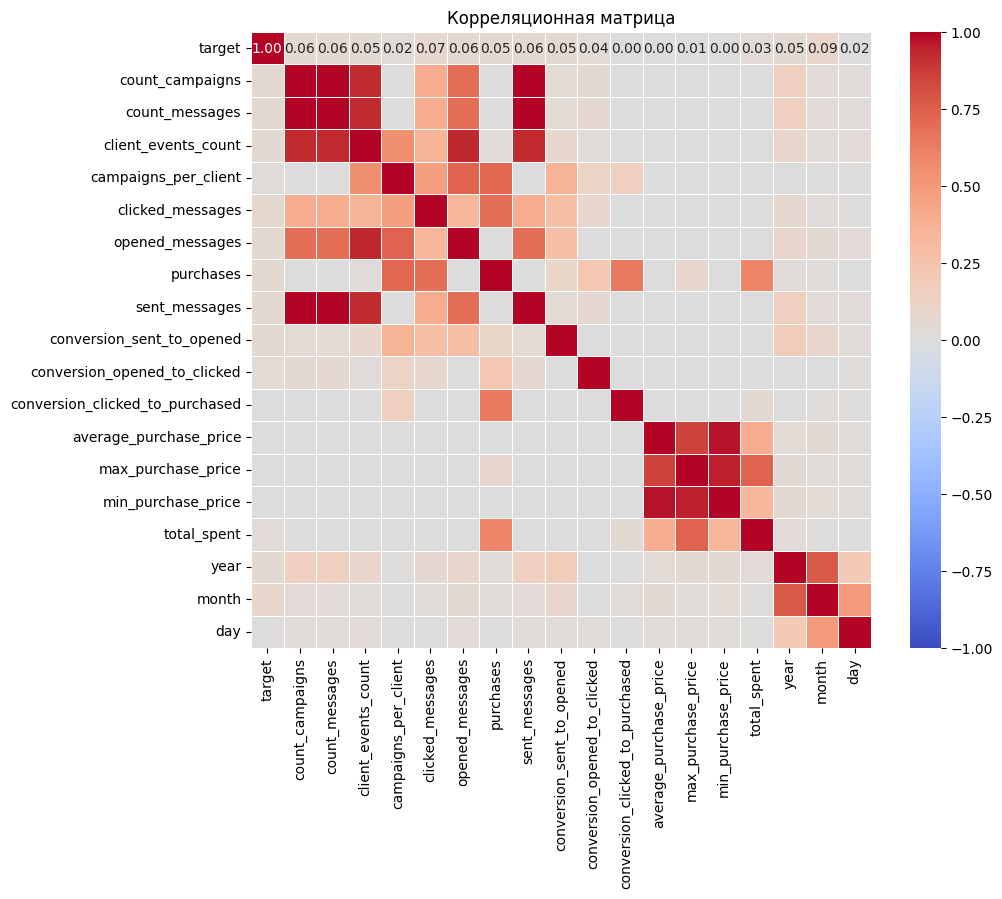

In [174]:

phik_matrix = df.phik_matrix()


plt.figure(figsize=(10, 8))
sns.heatmap(
    phik_matrix, 
    annot=True, 
    cmap='coolwarm', 
    fmt=".2f", 
    linewidths=0.5,
    vmin=-1,  
    vmax=1   
)
plt.title("Корреляционная матрица")
plt.show()

In [175]:
corr_spearman = df.corr(method='spearman')
corr_spearman

,target,count_campaigns,count_messages,client_events_count,campaigns_per_client,clicked_messages,opened_messages,purchases,sent_messages,conversion_sent_to_opened,conversion_opened_to_clicked,conversion_clicked_to_purchased,average_purchase_price,max_purchase_price,min_purchase_price,total_spent,year,month,day
target,1.000000,0.031091,0.031292,0.047376,0.034375,0.062648,0.044638,0.041705,0.031277,0.045127,0.013081,-0.018830,-0.042999,-0.015899,-0.057366,0.026297,0.068888,-0.019349,0.008127
count_campaigns,0.031091,1.000000,0.999855,0.952713,0.523777,0.535684,0.594241,0.489509,0.999825,0.382835,0.300301,0.352089,-0.007201,0.004707,-0.013106,-0.026585,-0.132030,-0.004339,0.005483
count_messages,0.031292,0.999855,1.000000,0.953260,0.527377,0.534279,0.594093,0.488780,0.999969,0.382977,0.296322,0.352475,-0.007687,0.004378,-0.013616,-0.026499,-0.129690,-0.003896,0.005543
client_events_count,0.047376,0.952713,0.953260,1.000000,0.625971,0.594619,0.772200,0.503168,0.953013,0.588196,0.305120,0.302203,-0.004184,0.013277,-0.016640,-0.012267,-0.119536,-0.000658,0.014067
campaigns_per_client,0.034375,0.523777,0.527377,0.625971,1.000000,0.655036,0.678659,0.614314,0.527100,0.647749,0.513256,0.352964,0.040764,0.059731,0.014939,0.043628,-0.109963,-0.014055,-0.000537
clicked_messages,0.062648,0.535684,0.534279,0.594619,0.655036,1.000000,0.495520,0.644411,0.534003,0.443869,0.622119,0.111628,0.014747,0.043912,-0.014678,0.022929,-0.075674,-0.013912,0.006172
opened_messages,0.044638,0.594241,0.594093,0.772200,0.678659,0.495520,1.000000,0.395345,0.593602,0.931237,0.398804,0.216642,0.029445,0.036383,0.018295,0.001070,-0.123734,-0.004577,0.021614
purchases,0.041705,0.489509,0.488780,0.503168,0.614314,0.644411,0.395345,1.000000,0.488685,0.359672,0.500058,0.696443,0.005517,0.086389,-0.080876,0.175469,-0.061512,0.005603,0.001507
sent_messages,0.031277,0.999825,0.999969,0.953013,0.527100,0.534003,0.593602,0.488685,1.000000,0.382419,0.296330,0.352638,-0.007660,0.004393,-0.013579,-0.026468,-0.129585,-0.003887,0.005491
conversion_sent_to_opened,0.045127,0.382835,0.382977,0.588196,0.647749,0.443869,0.931237,0.359672,0.382419,1.000000,0.409861,0.206695,0.033022,0.037830,0.022756,0.002576,-0.107662,0.000360,0.022001


## Ищем лучшую моделю заново

In [177]:
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

cat_columns = ['purchases']
num_columns = ['count_campaigns', 'count_messages', 'client_events_count', 'campaigns_per_client', 'clicked_messages', 
               'opened_messages', 'sent_messages', 'conversion_sent_to_opened', 'conversion_opened_to_clicked',
               'conversion_clicked_to_purchased', 'average_purchase_price', 'max_purchase_price', 'min_purchase_price',
               'total_spent', 'year', 'month', 'day']

In [178]:
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, cat_columns),
        ('num', numeric_transformer, num_columns)
    ]
)

In [179]:
lgbm_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'random_state': 42
}

catb_params = {
    'iterations': 1000,
    'depth': 10,
    'learning_rate': 0.03,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'od_type': 'Iter',
    'od_wait': 20,
    'random_seed': 42
}

rf_params = {
    'n_estimators': 200,
    'max_depth': 25,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'random_state': 42
}

In [180]:
models = {
    'LightGBM': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LGBMClassifier(**lgbm_params))
    ]),
    'Logistic Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(random_state=42))
    ]),
    'CatBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', CatBoostClassifier(**catb_params))
    ]),
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(**rf_params))
    ])
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [181]:
param_grids = {
    'LightGBM': {'classifier__num_leaves': [15, 31], 'classifier__min_data_in_leaf': [20, 50]},
    'Logistic Regression': {'classifier__C': [0.01, 0.1, 1.0]},
    'CatBoost': {'classifier__depth': [6, 10], 'classifier__l2_leaf_reg': [1, 3]},
    'Random Forest': {'classifier__max_depth': [None, 25], 'classifier__min_samples_split': [2, 5]}
}

In [183]:
best_models = {}
best_results= {}

for name, model in models.items():
    grid_search = GridSearchCV(model, param_grids[name], cv=cv, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_results[name] = {
        'score': grid_search.best_score_,
        'params': grid_search.best_params_
    }
    
    best_models[name] = grid_search.best_estimator_

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
0:	total: 12.9ms	remaining: 12.9s
1:	total: 25.5ms	remaini

In [184]:
best_model_name = max(best_results, key=lambda k: best_results[k]['score'])
best_model = best_models[best_model_name]

y_pred_probas = best_model.predict_proba(X_test)[:, 1]


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [185]:
test_auc = roc_auc_score(y_test, y_pred_probas)
print(f'Test ROC AUC for {best_model_name}: {test_auc:.2f}')

Test ROC AUC for LightGBM: 0.74


## Анализ важности признаков

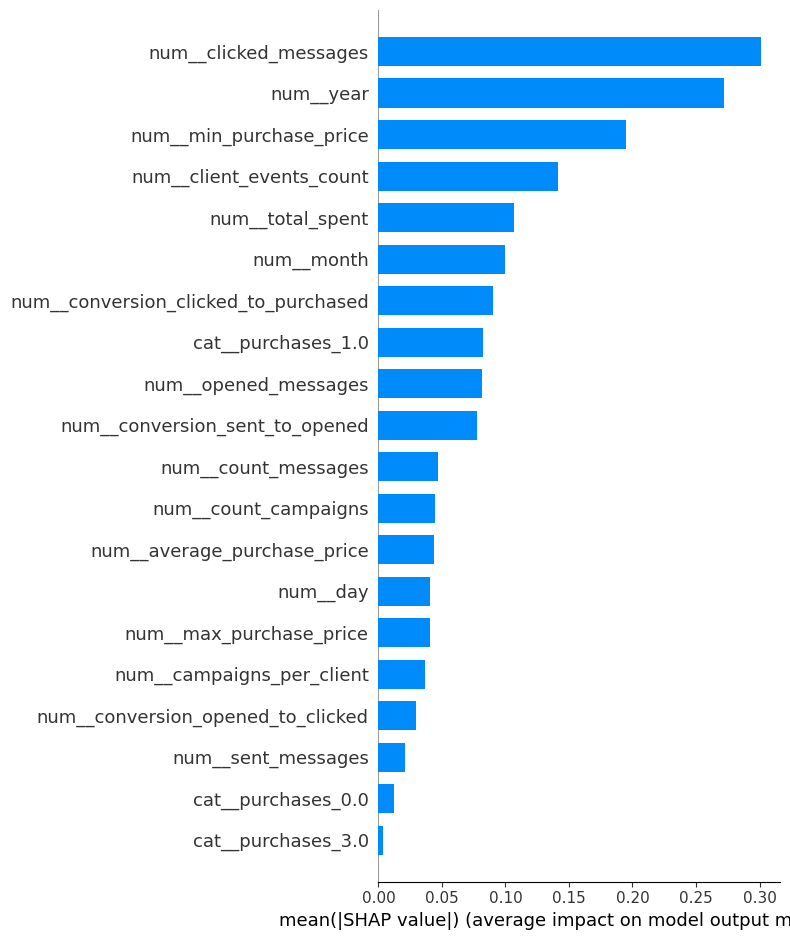

In [187]:
model_classifier = best_model.named_steps['classifier']

X_train_preprocessed = best_model['preprocessor'].transform(X_train)

column_names = best_model['preprocessor'].get_feature_names_out()

explainer = shap.TreeExplainer(model_classifier)
shap_values = explainer.shap_values(X_train_preprocessed)

shap.summary_plot(shap_values, features=X_train_preprocessed, feature_names=column_names, plot_type="bar")

Как видим на графике важнейшими признаками для определения модели были:
 - кликнет ли клиент в сообщении на ссылку;
 - год (будто бы это очень странно);
 - минимальная сумма покупки;
 - кол-во коммуникаций с клиентом;
 - общая сумма затрат.

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


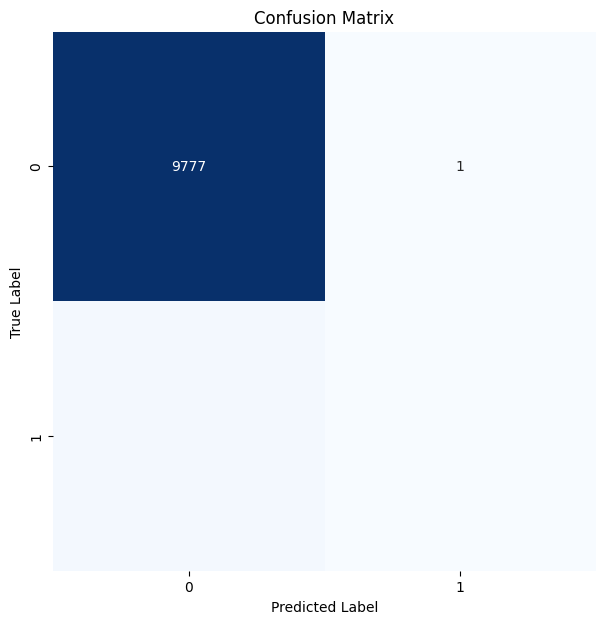

In [188]:
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Вывод

Итак, перед нами стояла вполне себе простая задача бинарной классификации: купит клиент или не купит. 
Датасеты изначально не имели пропусков, что значительно облегчило предобработку данных. 
Во время анализа был найдены некоторые интересные закономерности по которым создавались синтетические признаки и с помощью пайплайна было обучено несколько моелей. К сожалению, нужны результат метрики они не дали поэтому было решено изобрести другим способом создание синтетических признаков. Сами датасеты было гораздо проще соединить именно во втором случае. 

По итогам модель из 9 778 предсказала, что 9 777 не купят товар, что было действительно так, а 1 купит, но он тоже не купил... 

По итогам проведенной проектной работы есть предположение, что можно просто сделать вывод, будто в маркетплейсе нет ни одного постоянного покупателя. В данных изначально был жуткий дисбаланс классов, даже стратификация не помогла будто бы... 
Из рекомендаций: вместо ROC-AUC исопльзовать Precision чтобы минимизировать количество ложноположительных результатов, подготовить датасет в котором будет больше клиентов с покупкой ибо в данных перекос который вызывает подозрения. Не может 100%  клиентов не вренуться ахах
